# Fig. S4: Further clustering analysis

# import

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import interpolate
from sklearn.decomposition import SparsePCA
from scipy.stats import mannwhitneyu
from scipy import stats
from statannotations.Annotator import Annotator
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from scipy.integrate import simps
from sklearn.cluster import AgglomerativeClustering
import scikit_posthocs as sp

# --------------------------------------------------------------------------------------------------

# Load data

In [2]:
file_path = 'ADD_YOUR_PATH_TO_DATA_HERE'

# Ctrl 1
with open(file_path+'/ctrl_dataset_c1.pkl', 'rb') as handle:
    dict_c1 = pickle.load(handle)
    
# Ctrl 2
with open(file_path+'/ctrl_dataset_c2.pkl', 'rb') as handle:
    dict_c2 = pickle.load(handle)
    
# Ctrl
with open(file_path+'/no_dataset_c.pkl', 'rb') as handle:
    dict_c_no = pickle.load(handle)
    
# DETA/NO
with open(file_path+'/no_dataset_no.pkl', 'rb') as handle:
    dict_d_no = pickle.load(handle)

# --------------------------------------------------------------------------------------------------

# Cluster only type 32 from Ctrl (D) and Ctrl (C)

## Extract only type 32

In [83]:
# SbC Ctrl
idx_g32_ctrl = np.where(dict_c1['cell_type']==32)[0]
idx_g32_no = np.where(dict_c_no['cell_type']==32)[0]

print(idx_g32_ctrl.shape[0],idx_g32_no.shape[0])

251 135


# heatmap of all Ctrl type 32

In [84]:
# concatenate traces
control1 = np.hstack((dict_c1['chirp'],dict_c1['bar']))[idx_g32_ctrl]
control_d = np.hstack((dict_c_no['chirp'],dict_c_no['bar']))[idx_g32_no]

ctrl_both = np.vstack((control1,control_d))

# combines traces
ctrl_chirp_both = np.asarray(np.vstack((dict_c1['chirp'][idx_g32_ctrl],dict_c_no['chirp'][idx_g32_no])))
ctrl_bar_both = np.asarray(np.vstack((dict_c1['bar'][idx_g32_ctrl],dict_c_no['bar'][idx_g32_no])))

## standardize time bins

In [85]:
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

In [86]:
sc = StandardScaler()
control_stand = sc.fit_transform(ctrl_both)

In [87]:
print(control_stand.min(),control_stand.max())

-9.741738965572118 8.895919505623889


# sparse PCA: Grip search sparsity

# discard zero components

In [89]:
random_state=42
# MB
n_components_bar=10
spca = SparsePCA(n_components=n_components_bar, alpha=2, random_state=random_state)#,n_jobs=n_jobs)
spca.fit(ctrl_bar_both)
traces_transformed = spca.transform(ctrl_bar_both)
# chirp
n_components_chirp=30
spca_chirp = SparsePCA(n_components=n_components_chirp, alpha=3, random_state=random_state)#,n_jobs=n_jobs)
spca_chirp.fit(ctrl_chirp_both)
traces_transformed_chirp = spca_chirp.transform(ctrl_chirp_both)

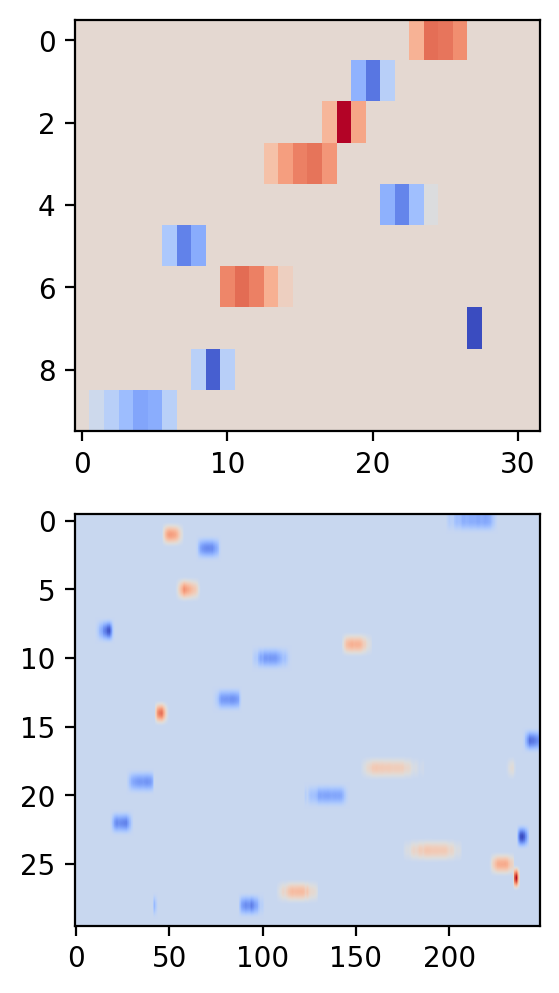

In [90]:
zero_comp_bar = np.where(np.mean(spca.components_,axis=1)==0)
zero_comp_chirp = np.where(np.mean(spca_chirp.components_,axis=1)==0)
fig,ax=plt.subplots(2,1,figsize=(3,6))
ax[0].imshow(spca.components_,aspect='auto',cmap='coolwarm')
ax[1].imshow(spca_chirp.components_,aspect='auto',cmap='coolwarm')

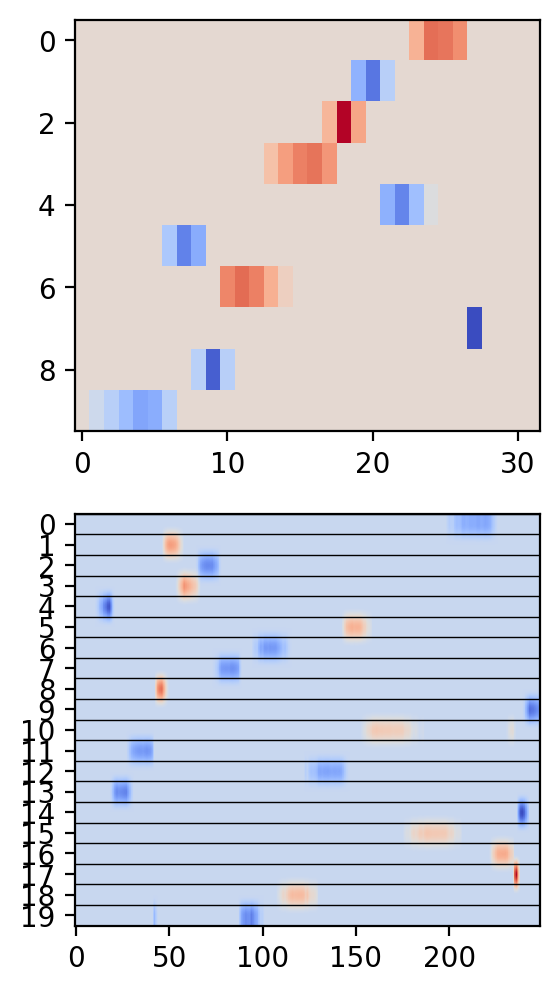

In [91]:
spca_com_bar = np.delete(spca.components_, zero_comp_bar, 0)
spca_com_chirp = np.delete(spca_chirp.components_, zero_comp_chirp, 0)
plt.rcParams['figure.dpi'] = 100

fig,ax=plt.subplots(2,1,figsize=(3,6))
ax[0].imshow(spca_com_bar,aspect='auto',cmap='coolwarm')
ax[1].imshow(spca_com_chirp,aspect='auto',cmap='coolwarm')
ax[1].set_yticks(np.arange(0,20,1));
for i in range(20):
    ax[1].axhline(i-.5,color='k',lw=0.5)

### sort components

In [92]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

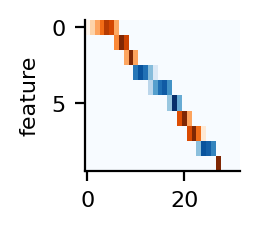

In [93]:
sort_spca_bar = [8,5,7,3,4,2,1,0,6]
sort_spca_bar = [9,5,8,6,3,2,1,4,0,7]

bar_spca_sorted = spca_com_bar[sort_spca_bar]

fig,ax=plt.subplots(1,1,figsize=(1,1))
cax = ax.imshow(bar_spca_sorted,aspect='auto',cmap=orange_blue,vmin=-.7,vmax=.7,interpolation='none')
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

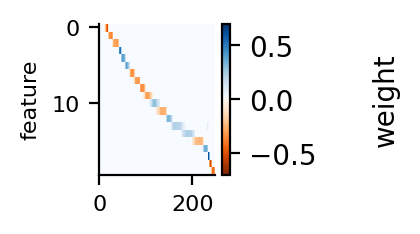

In [94]:
sort_spca_chirp = [4,13,11,8,1,3,2,7,19,6,18,12,5,10,15,0,16,17,14,9]
chirp_spca_sorted = spca_com_chirp[sort_spca_chirp]

fig,ax=plt.subplots(1,1,figsize=(1,1))
cax = ax.imshow(chirp_spca_sorted,aspect='auto',cmap=orange_blue,vmin=-0.7,vmax=0.7,interpolation='none')
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

fig.subplots_adjust(right=0.85)
cbar = fig.colorbar(cax)#, cax=cbar_ax)#, shrink=0.92)
cbar.set_label('weight', rotation=90)#,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

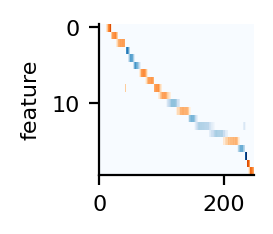

In [95]:
#sort_spca_chirp = [12,5,21,11,10,1,4,2,18,8,13,7,14,23,24,19,6,15,0,22,16,17,9,3,20]
sort_spca_chirp = [4,13,11,8,1,3,2,7,19,6,18,12,5,10,15,0,16,17,14,9]
chirp_spca_sorted = spca_com_chirp[sort_spca_chirp]

fig,ax=plt.subplots(1,1,figsize=(1,1))
cax = ax.imshow(chirp_spca_sorted,aspect='auto',cmap=orange_blue,vmin=-0.7,vmax=0.7,interpolation='none')
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

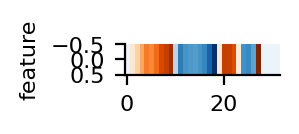

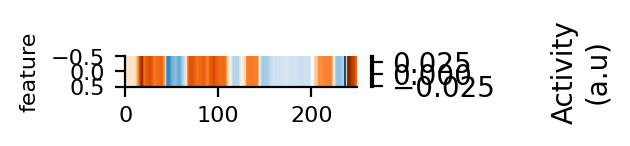

In [96]:
fig,ax=plt.subplots(1,1,figsize=(1,0.2))
ax.imshow(np.mean(bar_spca_sorted,axis=0)[:,None].T,aspect='auto',cmap=orange_blue)
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

figname = 'fig_6_sparse_features_bar_1D'
fig.patch.set_facecolor('white')
fig,ax=plt.subplots(1,1,figsize=(2,0.2))

cax = ax.imshow(np.mean(chirp_spca_sorted,axis=0)[:,None].T,aspect='auto',cmap=orange_blue)#,vmax=0.5,vmin=-.5)
ax.set_ylabel('feature',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()


fig.subplots_adjust(right=0.85)
#cbar_ax = fig.add_axes([0.88, 0.126, 0.03, 0.1])
cbar = fig.colorbar(cax)#, cax=cbar_ax)#, shrink=0.92)
cbar.set_label('Activity\n(a.u)', rotation=90)#,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20


figname = 'sparse_features_chirp_1D'
fig.patch.set_facecolor('white')

# Cluster with n=2

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

In [99]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [100]:
transformed_bar = np.delete(traces_transformed, zero_comp_bar, 1)
transformed_chirp = np.delete(traces_transformed_chirp, zero_comp_chirp, 1)

features = np.hstack((transformed_chirp,transformed_bar))
features_stand = sc.fit_transform(features)

In [101]:
#select 2 clusters
param_grid = {"n_components": range(1, 3), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)

GridSearchCV(cv=5, estimator=GaussianMixture(max_iter=1000, random_state=1112),
             param_grid={'covariance_type': ['diag'],
                         'n_components': range(1, 3)},
             scoring=<function gmm_bic_score at 0x7fca78ef1290>)

In [102]:
cluster_labels = grid_search.predict(features_stand)

In [103]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

Number of components Type of covariance    BIC score
1                    2               diag  6478.985229
0                    1               diag  6959.065197

In [104]:
n_cluster_lowest_bic = len(np.unique(cluster_labels))

In [105]:
n_cells_per_cluster_sbc = np.zeros(n_cluster_lowest_bic)
for i in range(n_cluster_lowest_bic):
    n_cells_per_cluster_sbc[i] = np.where(cluster_labels==i)[0].shape[0]

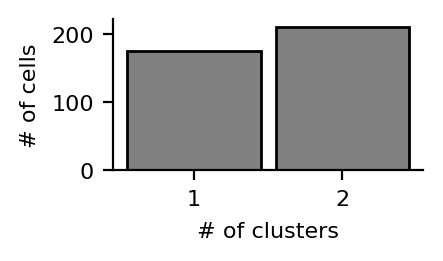

In [106]:
fig,ax=plt.subplots(1,1,figsize=(2,1))
ax.bar(np.arange(1,n_cluster_lowest_bic+1,1),n_cells_per_cluster_sbc,color='gray',edgecolor='k',width=.9);
#ax.set_title('SbC')
ax.set_xlabel('# of clusters',fontsize=8)
ax.set_ylabel('# of cells',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)

sns.despine()

figname = 'barplot_labels_crossval'
fig.patch.set_facecolor('white')
#fig.savefig("/gpfs01/euler/User/dgonschorek/projects/Gonschorek_2023_NO_RGCs/figures/final_figues/revised_figures/fig_5_clustering_G32/{}.png".format(figname), bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig("/gpfs01/euler/User/dgonschorek/projects/Gonschorek_2023_NO_RGCs/figures/final_figues/revised_figures/fig_5_clustering_G32/{}.svg".format(figname), bbox_inches='tight', dpi=300, facecolor=fig.get_facecolor(), transparent=False)

## Visualize clusters

In [107]:
plt.rcParams['figure.dpi'] = 100

In [108]:
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

In [110]:
chirp_label = np.hstack((cluster_labels[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels[:,None],ctrl_bar_both))

In [111]:
sorted_resp_matrix_chirp = np.zeros_like(chirp_label)
sorted_resp_matrix_bar = np.zeros_like(bar_label)
cluster_lines = np.zeros(n_cluster_lowest_bic)
counter=0
for i in range(n_cluster_lowest_bic):
    idx = np.where(cluster_labels==i)[0]
    sorted_resp_matrix_chirp[counter:counter+len(idx),:] = chirp_label[idx]
    sorted_resp_matrix_bar[counter:counter+len(idx),:] = bar_label[idx]
    cluster_lines[i]=len(idx)
    counter=counter+len(idx)

# plot with scan 2

In [114]:
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

In [115]:
chirp_label = np.hstack((cluster_labels[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels[:,None],ctrl_bar_both))

In [116]:
# combines traces scan 2
no_chirp_both = np.asarray(np.vstack((dict_c2['chirp'][idx_g32_ctrl],dict_d_no['chirp'][idx_g32_no])))
no_bar_both = np.asarray(np.vstack((dict_c2['bar'][idx_g32_ctrl],dict_d_no['bar'][idx_g32_no])))

In [117]:
cluster_labels_ctrl = cluster_labels[:dict_c2['chirp'][idx_g32_ctrl].shape[0]]
cluster_labels_no = cluster_labels[dict_c2['chirp'][idx_g32_ctrl].shape[0]:]

In [118]:
color_ctrl = 'tab:orange'
color_no = 'forestgreen'

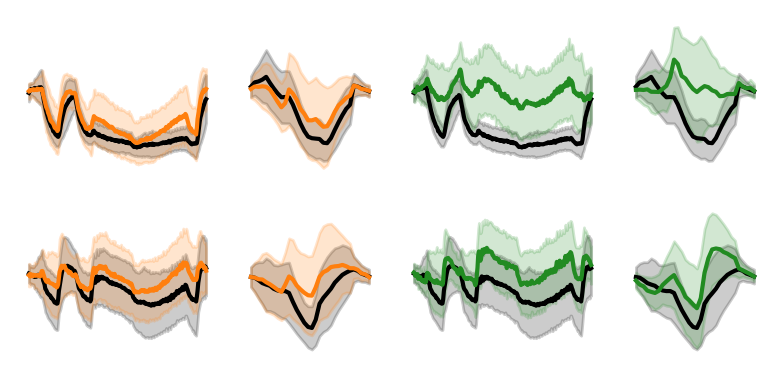

In [119]:
num_clusters = len(np.unique(cluster_labels))

fig,ax = plt.subplots(num_clusters,4,figsize=(4,2),gridspec_kw={'width_ratios': [3, 2, 3, 2,]},sharey=True)

for i in range(0,num_clusters):
    idx = np.where(cluster_labels==i)[0]
    # Ctrl 1
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx,:],axis=0),color='black')
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx,:],axis=0)+np.std(ctrl_chirp_both[idx,:],axis=0),np.mean(ctrl_chirp_both[idx,:],axis=0)-np.std(ctrl_chirp_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(ctrl_bar_both[idx,:],axis=0),color='black')
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx,:],axis=0)+np.std(ctrl_bar_both[idx,:],axis=0),np.mean(ctrl_bar_both[idx,:],axis=0)-np.std(ctrl_bar_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,1].axis('off')
    
    # Ctrl 2
    idx = np.where(cluster_labels_ctrl==i)[0]
    ax[i,0].plot(np.mean(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0),color=color_ctrl)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0)+np.std(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0),np.mean(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0)-np.std(dict_c2['chirp'][idx_g32_ctrl][idx,:],axis=0),alpha=0.2,color=color_ctrl)
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0),color=color_ctrl)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0)+np.std(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0),np.mean(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0)-np.std(dict_c2['bar'][idx_g32_ctrl][idx,:],axis=0),alpha=0.2,color=color_ctrl)
    ax[i,1].axis('off')
    
    
##########################   
    # Ctrl 1
    idx = np.where(cluster_labels==i)[0]
    ax[i,2].plot(np.mean(ctrl_chirp_both[idx,:],axis=0),color='black')
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx,:],axis=0)+np.std(ctrl_chirp_both[idx,:],axis=0),np.mean(ctrl_chirp_both[idx,:],axis=0)-np.std(ctrl_chirp_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,2].axis('off')
    
    ax[i,3].plot(np.mean(ctrl_bar_both[idx,:],axis=0),color='black')
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx,:],axis=0)+np.std(ctrl_bar_both[idx,:],axis=0),np.mean(ctrl_bar_both[idx,:],axis=0)-np.std(ctrl_bar_both[idx,:],axis=0),alpha=0.2,color='black')
    ax[i,3].axis('off')
    
    # DETA/NO
    idx = np.where(cluster_labels_no==i)[0]
    ax[i,2].plot(np.mean(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0),color=color_no)
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0)+np.std(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0),np.mean(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0)-np.std(dict_d_no['chirp'][idx_g32_no][idx,:],axis=0),alpha=0.2,color=color_no)
    ax[i,2].axis('off')
    #ax[i,2].set_title('ID: ' + str(i))# + ' Ctrl/NO\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,3].plot(np.mean(dict_d_no['bar'][idx_g32_no][idx,:],axis=0),color=color_no)
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(dict_d_no['bar'][idx_g32_no][idx,:],axis=0)+np.std(dict_d_no['bar'][idx_g32_no][idx,:],axis=0),np.mean(dict_d_no['bar'][idx_g32_no][idx,:],axis=0)-np.std(dict_d_no['bar'][idx_g32_no][idx,:],axis=0),alpha=0.2,color=color_no)
    ax[i,3].axis('off')
    
fig.tight_layout()    

In [120]:
ctrl_dsp_both = np.asarray(np.vstack((dict_c1['dsp'][idx_g32_ctrl][:,None],dict_c_no['dsp'][idx_g32_no][:,None])))
ctrl_osi_both = np.asarray(np.vstack((dict_c1['osi'][idx_g32_ctrl][:,None],dict_c_no['osi'][idx_g32_no][:,None])))
ctrl_dsi_both = np.asarray(np.vstack((dict_c1['dsi'][idx_g32_ctrl][:,None],dict_c_no['dsi'][idx_g32_no][:,None])))
ctrl_pol_idx_both = np.asarray(np.vstack((dict_c1['pol_idx'][idx_g32_ctrl][:,None],dict_c_no['pol_idx'][idx_g32_no][:,None])))
ctrl_trans_idx_both = np.asarray(np.vstack((dict_c1['trans_idx'][idx_g32_ctrl][:,None],dict_c_no['trans_idx'][idx_g32_no][:,None])))

## distribution per condition of cells per cluster

In [121]:
# get lines to separate clusters
cluster_lines_ctrl = np.zeros(n_cluster_lowest_bic)
counter=0
for i in range(n_cluster_lowest_bic):
    idx = np.where(cluster_labels_ctrl==i)[0]
    cluster_lines_ctrl[i]=len(idx)
    counter=counter+len(idx)
    
cluster_lines_no = np.zeros(n_cluster_lowest_bic)
counter=0
for i in range(n_cluster_lowest_bic):
    idx = np.where(cluster_labels_no==i)[0]
    cluster_lines_no[i]=len(idx)
    counter=counter+len(idx)    

In [122]:
perc_clusters_ctrl = cluster_lines_ctrl/234*100
perc_clusters_no = cluster_lines_no/135*100

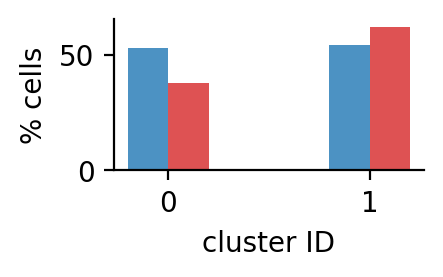

In [123]:
fig,ax = plt.subplots(1,1,figsize=(2,1))
ax.bar(np.arange(0,2,1)-0.1, perc_clusters_ctrl, width=0.2, color='tab:blue', align='center',alpha=0.8,label='ctrl')
ax.bar(np.arange(0,2,1)+0.1, perc_clusters_no, width=0.2, color='tab:red', align='center',alpha=0.8,label='NO')
ax.set_ylabel('% cells')
ax.set_xlabel('cluster ID')
#ax.legend(loc=1,frameon=False)
sns.despine()

# compute indices and differences

In [124]:
c1_label_chirp = []
c1_label_bar = []
c2_label_chirp = []
c2_label_bar = []

c_label_chirp = []
c_label_bar = []
d_label_chirp = []
d_label_bar = []

for i in range(0,3):
    idx = np.where(cluster_labels_ctrl==i)[0]
    c1_label_chirp.append(dict_c1['chirp'][idx_g32_ctrl][idx,:])
    c1_label_bar.append(dict_c1['bar'][idx_g32_ctrl][idx,:])
    c2_label_chirp.append(dict_c2['chirp'][idx_g32_ctrl][idx,:])
    c2_label_bar.append(dict_c2['bar'][idx_g32_ctrl][idx,:])    
    
    idx = np.where(cluster_labels_no==i)[0]
    c_label_chirp.append(dict_c_no['chirp'][idx_g32_no][idx,:])
    c_label_bar.append(dict_c_no['bar'][idx_g32_no][idx,:])
    d_label_chirp.append(dict_d_no['chirp'][idx_g32_no][idx,:])
    d_label_bar.append(dict_d_no['bar'][idx_g32_no][idx,:])    
    
c1_label_chirp = np.vstack(c1_label_chirp)
c1_label_bar = np.vstack(c1_label_bar)
c2_label_chirp = np.vstack(c2_label_chirp)
c2_label_bar = np.vstack(c2_label_bar)

c_label_chirp = np.vstack(c_label_chirp)
c_label_bar = np.vstack(c_label_bar)
d_label_chirp = np.vstack(d_label_chirp)
d_label_bar = np.vstack(d_label_bar)

## suppression index

In [125]:
from scipy.integrate import simps
def suppression_index(data):
    auc_pos = simps(np.clip(data,0.01,1))
    auc_neg = simps(np.clip(data,-1,-0.01))
    total_auc = abs(auc_pos)+abs(auc_neg)
    sup_idx = abs(auc_neg)/total_auc
    
    return sup_idx

In [126]:
c1_both = np.hstack((c1_label_chirp,c1_label_bar))
c2_both = np.hstack((c2_label_chirp,c2_label_bar))
c_no_both = np.hstack((c_label_chirp,c_label_bar))
d_no_both = np.hstack((d_label_chirp,d_label_bar))

In [127]:
c1_both = deepcopy(c1_label_chirp)
c2_both = deepcopy(c2_label_chirp)
c_no_both = deepcopy(c_label_chirp)
d_no_both = deepcopy(d_label_chirp)

In [128]:
sup_idx_c1 = np.zeros(c1_label_chirp.shape[0])    
sup_idx_c2 = np.zeros(c1_label_chirp.shape[0])    
sup_idx_c_no = np.zeros(c_label_chirp.shape[0])    
sup_idx_d_no = np.zeros(c_label_chirp.shape[0])    

for i in range(c1_both.shape[0]):
    sup_idx_c1[i] = suppression_index(c1_both[i,:])
    sup_idx_c2[i] = suppression_index(c2_both[i,:])

for i in range(c_no_both.shape[0]):
    sup_idx_c_no[i] = suppression_index(c_no_both[i,:])
    sup_idx_d_no[i] = suppression_index(d_no_both[i,:])
    
sup_scan_1 = np.concatenate((sup_idx_c1,sup_idx_c_no))
sup_scan_2 = np.concatenate((sup_idx_c2,sup_idx_d_no))

In [129]:
sup_idx_all = np.concatenate((sup_idx_c1,sup_idx_c_no,sup_idx_c2,sup_idx_d_no))
cluster_ids_all = np.concatenate((cluster_labels_ctrl,cluster_labels_no,cluster_labels_ctrl,cluster_labels_no))
ctrl_cond_str = ['ctrl'] * cluster_labels_ctrl.shape[0]
ctrl_no_cond_str = ['ctrl'] * cluster_labels_no.shape[0]
ctrl2_cond_str = ['ctrl2'] * cluster_labels_ctrl.shape[0]
no_cond_str = ['NO']*cluster_labels_no.shape[0]
condition_all_str = np.concatenate((ctrl_cond_str,ctrl_no_cond_str,ctrl2_cond_str,no_cond_str))

df_si = pd.DataFrame({'sup_idx':sup_idx_all,'cluster':cluster_ids_all,'condition':condition_all_str})

## sup. idx difference (pairwise)

In [130]:
diff_si_ctrl = sup_idx_c2-sup_idx_c1
diff_si_no = sup_idx_d_no-sup_idx_c_no

diff_si = np.concatenate((diff_si_ctrl,diff_si_no))
cluster_ids_all_si = np.concatenate((cluster_labels_ctrl,cluster_labels_no))
condition_all_si = np.concatenate((ctrl_cond_str,no_cond_str))

df_si_diff = pd.DataFrame({'sup_idx_diff':diff_si,'cluster':cluster_ids_all_si,'condition':condition_all_si})

## mean trace difference

In [131]:
n_cells_cluster_ctrl = np.cumsum(cluster_lines_ctrl)
n_cells_cluster_no = np.cumsum(cluster_lines_no)

In [132]:
diff_ctrl = []
diff_no = []
for i in range(0,3):
    idx = np.where(cluster_labels_ctrl==i)[0]
    c1_both = np.hstack((dict_c1['chirp'][idx_g32_ctrl][idx,:],dict_c1['bar'][idx_g32_ctrl][idx,:]))
    c2_both = np.hstack((dict_c2['chirp'][idx_g32_ctrl][idx,:],dict_c2['bar'][idx_g32_ctrl][idx,:]))
    diff_ctrl.append(np.mean(c2_both-c1_both,axis=1))
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both = np.hstack((dict_c_no['chirp'][idx_g32_no][idx,:],dict_c_no['bar'][idx_g32_no][idx,:]))
    no_both = np.hstack((dict_d_no['chirp'][idx_g32_no][idx,:],dict_d_no['bar'][idx_g32_no][idx,:]))
    diff_no.append(np.mean(no_both-c_both,axis=1))
        
diff_ctrl = np.concatenate(diff_ctrl)
diff_no = np.concatenate(diff_no)

diff_both = np.concatenate((diff_ctrl,diff_no))

In [134]:
cluster_label_ctrl_str = []
cluster_label_no_str = []
for i in range(0,2):
    cluster_label_ctrl_str.append([str(i+1)]*int(cluster_lines_ctrl[i]))
    cluster_label_no_str.append([str(i+1)]*int(cluster_lines_no[i]))
cluster_ids_df = np.concatenate((np.concatenate(cluster_label_ctrl_str),np.concatenate(cluster_label_no_str)))
condition_str = np.concatenate((['ctrl']*int(n_cells_cluster_ctrl[-1]),['no']*int(n_cells_cluster_no[-1])))
df_diff = pd.DataFrame({'diff':diff_both,'cluster':cluster_ids_df,'condition':condition_str})

## MSE

In [135]:
from sklearn.metrics import mean_squared_error

In [136]:
mse_ctrl = []
mse_no = []
for i in range(0,2):
    idx = np.where(cluster_labels_ctrl==i)[0]
    c1_both = np.hstack((dict_c1['chirp'][idx_g32_ctrl][idx,:],dict_c1['bar'][idx_g32_ctrl][idx,:]))
    c2_both = np.hstack((dict_c2['chirp'][idx_g32_ctrl][idx,:],dict_c2['bar'][idx_g32_ctrl][idx,:]))
    temp = np.zeros(dict_c1['chirp'][idx_g32_ctrl][idx,:].shape[0])
    for j in range(temp.shape[0]):
        temp[j] = mean_squared_error(c2_both[j,:],c1_both[j,:])
    mse_ctrl.append(temp)
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both = np.hstack((dict_c_no['chirp'][idx_g32_no][idx,:],dict_c_no['bar'][idx_g32_no][idx,:]))
    no_both = np.hstack((dict_d_no['chirp'][idx_g32_no][idx,:],dict_d_no['bar'][idx_g32_no][idx,:]))
    temp = np.zeros(dict_d_no['chirp'][idx_g32_no][idx,:].shape[0])
    for j in range(temp.shape[0]):
        temp[j] = mean_squared_error(no_both[j,:],c_both[j,:])
    mse_no.append(temp)
        
mse_ctrl = np.concatenate(mse_ctrl)
mse_no = np.concatenate(mse_no)

mse_both = np.concatenate((mse_ctrl,mse_no))

In [137]:
df_mse = pd.DataFrame({'mse':mse_both,'cluster':cluster_ids_df,'condition':condition_str})

# -----------------------------------------------------------------------------------------------------------------

# Clean cluster 2

# Hierarchical clustering of cluster 2

In [140]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [141]:
idx_cluster_2=cluster_labels==1

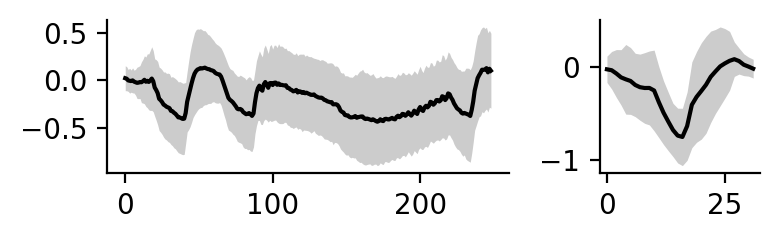

In [142]:
fig,ax=plt.subplots(1,2,figsize=(4,1.3),gridspec_kw={'width_ratios': [2.5, 1.]})
ax[0].plot(np.mean(ctrl_chirp_both[idx_cluster_2],axis=0),color='k')
ax[1].plot(np.mean(ctrl_bar_both[idx_cluster_2],axis=0),color='k')

ax[0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2,:],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2,:],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2,:],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2,:],axis=0)+np.std(ctrl_bar_both[idx_cluster_2,:],axis=0),np.mean(ctrl_bar_both[idx_cluster_2,:],axis=0)-np.std(ctrl_bar_both[idx_cluster_2,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
sns.despine()
fig.tight_layout()

In [143]:
ctrl_both_32 = np.hstack((ctrl_chirp_both[idx_cluster_2],ctrl_bar_both[idx_cluster_2]))

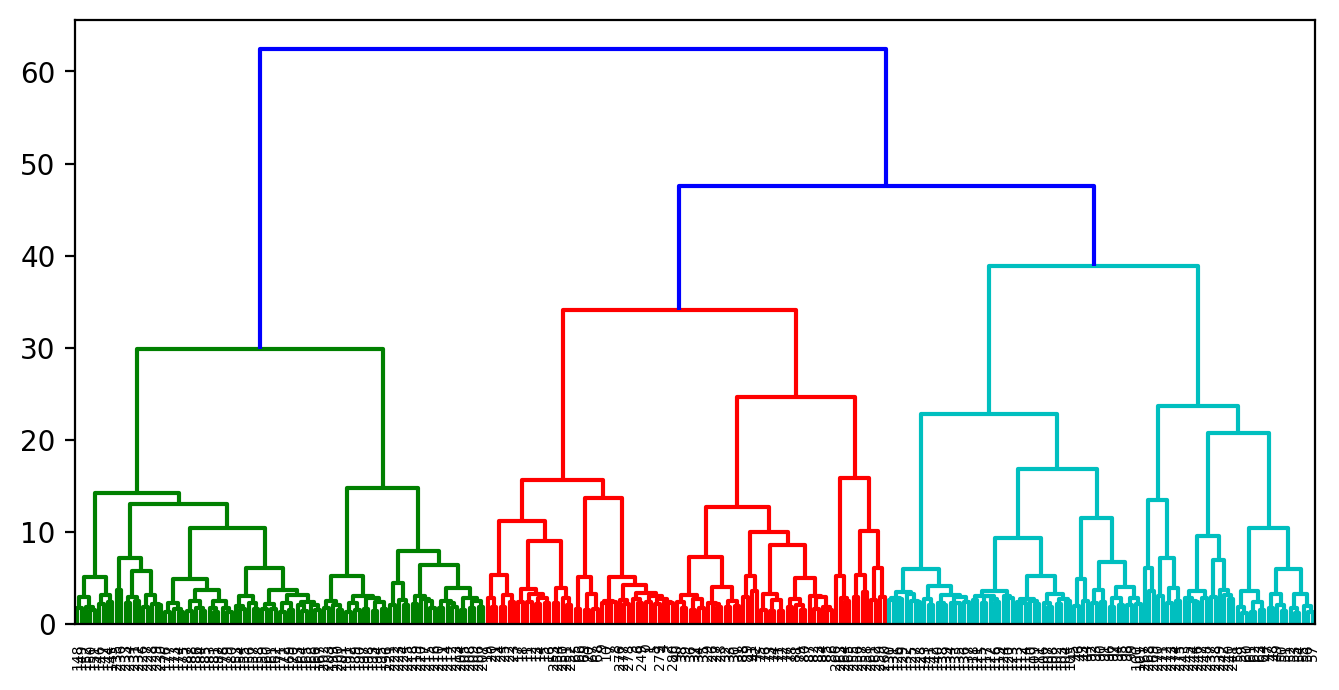

In [144]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
linkage_data = linkage(ctrl_both_32.T, method='ward', metric='euclidean')#,distance_threshold=avg_dist[:30,:30].mean())
dendrogram(linkage_data);
#plt.show() 

In [145]:
n_cluster_cleaned=4

In [146]:
clustering_model = AgglomerativeClustering(n_clusters=n_cluster_cleaned,affinity='euclidean', linkage='ward')
clustering_model.fit(ctrl_both_32)

AgglomerativeClustering(n_clusters=4)

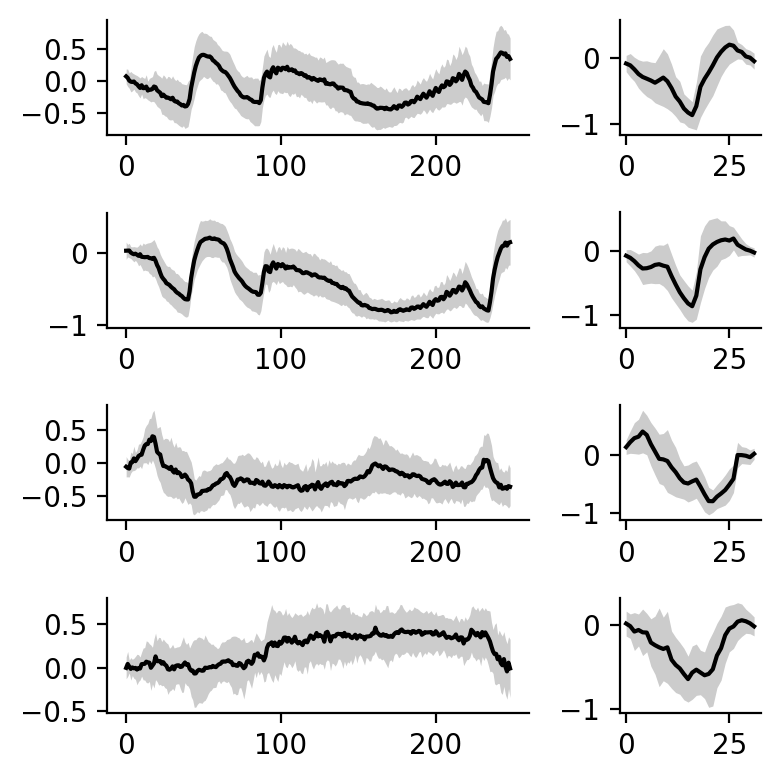

In [148]:
fig,ax = plt.subplots(n_cluster_cleaned,2,figsize=(4,4),gridspec_kw={'width_ratios': [3, 1]})#,sharey=True)

for i in range(0,n_cluster_cleaned):
    idx = np.where(clustering_model.labels_==i)[0]
    
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0),color='k')
    ax[i,1].plot(np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0),color='k')

    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2,:][idx],axis=0)+np.std(ctrl_bar_both[idx_cluster_2,:][idx],axis=0),np.mean(ctrl_bar_both[idx_cluster_2,:][idx],axis=0)-np.std(ctrl_bar_both[idx_cluster_2,:][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')


sns.despine()
fig.tight_layout()

# Only pick cluster 3 and reject the rest

In [149]:
# combines traces of scan 2
ctrl_chirp_both_scan2 = np.asarray(np.vstack((dict_c2['chirp'][idx_g32_ctrl],dict_d_no['chirp'][idx_g32_no])))
ctrl_bar_both_scan2 = np.asarray(np.vstack((dict_c2['bar'][idx_g32_ctrl],dict_d_no['bar'][idx_g32_no])))

ctrl_both_32_scan2 = np.hstack((ctrl_chirp_both_scan2[idx_cluster_2],ctrl_bar_both_scan2[idx_cluster_2]))

In [150]:
idx1 = np.where(clustering_model.labels_==0)[0]
idx2 = np.where(clustering_model.labels_==1)[0]
idx = np.hstack((idx1,idx2))

In [151]:
idx_ctrl_dataset_1 = np.where(label_dataset[idx_cluster_2][idx]==0)[0]
idx_ctrl_dataset_2 = np.where(label_dataset[idx_cluster_2][idx]==1)[0]

(-1.55, 32.55, -1.1900622910735135, 1.025784383417436)

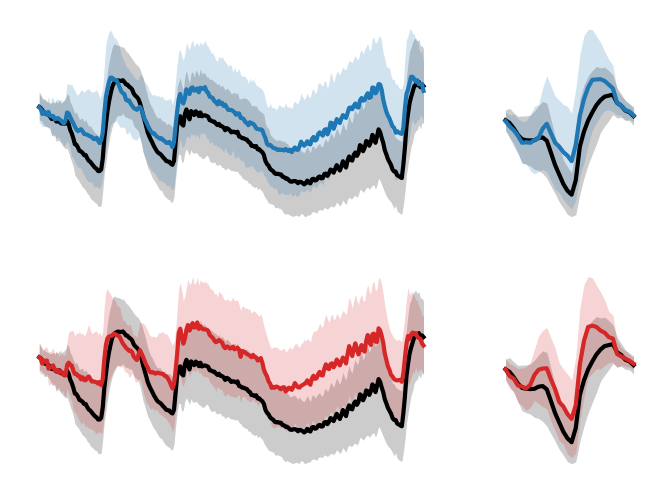

In [152]:
fig,ax = plt.subplots(2,2,figsize=(4,3),gridspec_kw={'width_ratios': [3, 1]})#,sharey=True)


#idx = np.where(clustering_model.labels_==0)[0]
# chirp ctrl 2
ax[0,0].plot(np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0),color='k')
ax[0,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2][idx],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[0,0].axis('off')
ax[0,0].plot(np.mean(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0),color='tab:blue')
ax[0,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0)+np.std(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0),np.mean(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0)-np.std(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='tab:blue')
# chirp NO
ax[1,0].plot(np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0),color='k')
ax[1,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2][idx],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[1,0].plot(np.mean(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0),color='tab:red')
ax[1,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0)+np.std(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0),np.mean(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0)-np.std(ctrl_chirp_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='tab:red')
ax[1,0].axis('off')

# bar ctrl 2
ax[0,1].plot(np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0),color='k')
ax[0,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0)+np.std(ctrl_bar_both[idx_cluster_2][idx],axis=0),np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0)-np.std(ctrl_bar_both[idx_cluster_2][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[0,1].axis('off')
ax[0,1].plot(np.mean(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0),color='tab:blue')
ax[0,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0)+np.std(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0),np.mean(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0)-np.std(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_1],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='tab:blue')
# bar NO
ax[1,1].plot(np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0),color='k')
ax[1,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0)+np.std(ctrl_bar_both[idx_cluster_2][idx],axis=0),np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0)-np.std(ctrl_bar_both[idx_cluster_2][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[1,1].plot(np.mean(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0),color='tab:red')
ax[1,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0)+np.std(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0),np.mean(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0)-np.std(ctrl_bar_both_scan2[idx_cluster_2][idx][idx_ctrl_dataset_2],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='tab:red')
ax[1,1].axis('off')

# visualize traces with cleaned cluster 2

In [153]:
#idx_label_2 = np.where(clustering_model.labels_==0)[0]
idx_label_others = np.where(clustering_model.labels_==2)[0]

# extract only cluster 2 cells that were reclustered
idx_cluster_2 = np.where(cluster_labels==1)[0]

# assign another label to the clusters that will be rejcted
cluster_labels_re = cluster_labels.copy()
cluster_labels_re[idx_cluster_2[idx_label_others]]=3

In [154]:
chirp_label = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels_re[:,None],ctrl_bar_both))

In [155]:
sorted_resp_matrix_chirp = np.zeros_like(chirp_label)
sorted_resp_matrix_bar = np.zeros_like(bar_label)
cluster_lines = np.zeros(n_cluster_lowest_bic+1)
counter=0
for i in range(n_cluster_lowest_bic+1):
    idx = np.where(cluster_labels_re==i)[0]
    sorted_resp_matrix_chirp[counter:counter+len(idx),:] = chirp_label[idx]
    sorted_resp_matrix_bar[counter:counter+len(idx),:] = bar_label[idx]
    cluster_lines[i]=len(idx)
    counter=counter+len(idx)

# Repeat plotting and analysis including cleaned cluster

# compute indices and differences

In [156]:
chirp_ctrl_label_scan1 = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both))
bar_ctrl_label_scan1 = np.hstack((cluster_labels_re[:,None],ctrl_bar_both))

chirp_ctrl_label_scan2 = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both_scan2))
bar_ctrl_label_scan2 = np.hstack((cluster_labels_re[:,None],ctrl_bar_both_scan2))

In [238]:
ctrl_c1_chirp = chirp_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_chirp = chirp_ctrl_label_scan2[np.where(label_dataset==0)[0]]
ctrl_c1_bar = bar_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_bar = bar_ctrl_label_scan2[np.where(label_dataset==0)[0]]

ctrl_c_chirp = chirp_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_chirp = chirp_ctrl_label_scan2[np.where(label_dataset==1)[0]]
ctrl_c_bar = bar_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_bar = bar_ctrl_label_scan2[np.where(label_dataset==1)[0]]

In [159]:
idx_good_types_ctrl = np.where(ctrl_c1_chirp[:,0]!=3)[0]
idx_good_types_no = np.where(ctrl_c_chirp[:,0]!=3)[0]

In [160]:
ctrl_c1_chirp = ctrl_c1_chirp[idx_good_types_ctrl]
ctrl_c2_chirp = ctrl_c2_chirp[idx_good_types_ctrl]
ctrl_c1_bar = ctrl_c1_bar[idx_good_types_ctrl]
ctrl_c2_bar = ctrl_c2_bar[idx_good_types_ctrl]

ctrl_c_chirp = ctrl_c_chirp[idx_good_types_no]
ctrl_no_chirp = ctrl_no_chirp[idx_good_types_no]
ctrl_c_bar = ctrl_c_bar[idx_good_types_no]
ctrl_no_bar = ctrl_no_bar[idx_good_types_no]

# sort 

ctrl_c1_chirp = ctrl_c1_chirp[ctrl_c1_chirp[:,0].argsort()]
ctrl_c2_chirp = ctrl_c2_chirp[ctrl_c2_chirp[:,0].argsort()]
ctrl_c1_bar = ctrl_c1_bar[ctrl_c1_chirp[:,0].argsort()]
ctrl_c2_bar = ctrl_c2_bar[ctrl_c2_chirp[:,0].argsort()]

ctrl_c_chirp = ctrl_c_chirp[ctrl_c_chirp[:,0].argsort()]
ctrl_no_chirp = ctrl_no_chirp[ctrl_no_chirp[:,0].argsort()]
ctrl_c_bar = ctrl_c_bar[ctrl_c_chirp[:,0].argsort()]
ctrl_no_bar = ctrl_no_bar[ctrl_no_chirp[:,0].argsort()]

## suppression index

In [164]:
from scipy.integrate import simps
def suppression_index(data):
    auc_pos = simps(np.clip(data,0.01,1))
    auc_neg = simps(np.clip(data,-1,-0.01))
    total_auc = abs(auc_pos)+abs(auc_neg)
    sup_idx = abs(auc_neg)/total_auc
    
    return sup_idx

In [165]:
c1_both = np.hstack((ctrl_c1_chirp[:,1:],ctrl_c1_bar[:,1:]))
c2_both = np.hstack((ctrl_c2_chirp[:,1:],ctrl_c2_bar[:,1:]))
c_no_both = np.hstack((ctrl_c_chirp[:,1:],ctrl_c_bar[:,1:]))
d_no_both = np.hstack((ctrl_no_chirp[:,1:],ctrl_no_bar[:,1:]))

In [166]:
sup_idx_c1 = np.zeros(c1_both.shape[0])    
sup_idx_c2 = np.zeros(c1_both.shape[0])    
sup_idx_c_no = np.zeros(c_no_both.shape[0])    
sup_idx_d_no = np.zeros(c_no_both.shape[0])    

for i in range(c1_both.shape[0]):
    sup_idx_c1[i] = suppression_index(c1_both[i,:])
    sup_idx_c2[i] = suppression_index(c2_both[i,:])

for i in range(c_no_both.shape[0]):
    sup_idx_c_no[i] = suppression_index(c_no_both[i,:])
    sup_idx_d_no[i] = suppression_index(d_no_both[i,:])
    
sup_scan_1 = np.concatenate((sup_idx_c1,sup_idx_c_no))
sup_scan_2 = np.concatenate((sup_idx_c2,sup_idx_d_no))

In [167]:
cluster_labels_ctrl = cluster_labels_re[np.where(label_dataset==0)[0]][idx_good_types_ctrl]
cluster_labels_no = cluster_labels_re[np.where(label_dataset==1)[0]][idx_good_types_no]

In [168]:
sup_idx_all = np.concatenate((sup_idx_c1,sup_idx_c_no,sup_idx_c2,sup_idx_d_no))
cluster_ids_all = np.concatenate((cluster_labels_ctrl,cluster_labels_no,cluster_labels_ctrl,cluster_labels_no))
ctrl_cond_str = ['ctrl'] * cluster_labels_ctrl.shape[0]
ctrl_no_cond_str = ['ctrl'] * cluster_labels_no.shape[0]
ctrl2_cond_str = ['ctrl2'] * cluster_labels_ctrl.shape[0]
no_cond_str = ['NO']*cluster_labels_no.shape[0]
condition_all_str = np.concatenate((ctrl_cond_str,ctrl_no_cond_str,ctrl2_cond_str,no_cond_str))

df_si = pd.DataFrame({'sup_idx':sup_idx_all,'cluster':cluster_ids_all,'condition':condition_all_str})

## sup. idx difference (pairwise)

In [169]:
diff_si_ctrl = sup_idx_c2-sup_idx_c1
diff_si_no = sup_idx_d_no-sup_idx_c_no

diff_si = np.concatenate((diff_si_ctrl,diff_si_no))
cluster_ids_all_si = np.concatenate((cluster_labels_ctrl,cluster_labels_no))
condition_all_si = np.concatenate((ctrl_cond_str,no_cond_str))

df_si_diff = pd.DataFrame({'sup_idx_diff':diff_si,'cluster':cluster_ids_all_si,'condition':condition_all_si})

## mean trace difference

In [170]:
n_cells_cluster_ctrl = np.cumsum(cluster_lines_ctrl)
n_cells_cluster_no = np.cumsum(cluster_lines_no)

In [171]:
diff_ctrl = []
diff_no = []
for i in range(0,3):
    idx = np.where(cluster_labels_ctrl==i)[0]
    c1_both_temp = c1_both[idx,:]
    c2_both_temp = c2_both[idx,:]
    diff_ctrl.append(np.mean(c2_both_temp-c1_both_temp,axis=1))
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both_temp = c_no_both[idx,:]
    no_both_temp = d_no_both[idx,:]
    diff_no.append(np.mean(no_both_temp-c_both_temp,axis=1))
        
diff_ctrl = np.concatenate(diff_ctrl)
diff_no = np.concatenate(diff_no)

diff_both = np.concatenate((diff_ctrl,diff_no))

In [172]:
cluster_label_ctrl_str = []
cluster_label_no_str = []
for i in range(0,2):
    cluster_label_ctrl_str.append([str(i+1)]*int(cluster_lines_ctrl[i]))
    cluster_label_no_str.append([str(i+1)]*int(cluster_lines_no[i]))

In [173]:
cluster_label_ctrl = ctrl_c1_chirp[:,0].copy()
cluster_label_no = ctrl_c_chirp[:,0].copy()
cluster_ids_df = np.concatenate((cluster_label_ctrl,cluster_label_no))

In [174]:
condition_str = np.concatenate((['ctrl']*int(diff_ctrl.shape[0]),['no']*int(diff_no.shape[0])))
df_diff = pd.DataFrame({'diff':diff_both,'cluster':cluster_ids_df.astype('int'),'condition':condition_str})

## plotting

In [175]:
from statannotations.Annotator import Annotator

In [176]:
X = np.random.randint(1,ctrl_chirp_both.shape[0], ctrl_chirp_both.shape[0])

In [177]:
ctrl_chirp_both_pseudo_shuffled = np.hstack((X[:,None],ctrl_chirp_both))
ctrl_bar_both_pseudo_shuffled = np.hstack((X[:,None],ctrl_bar_both))

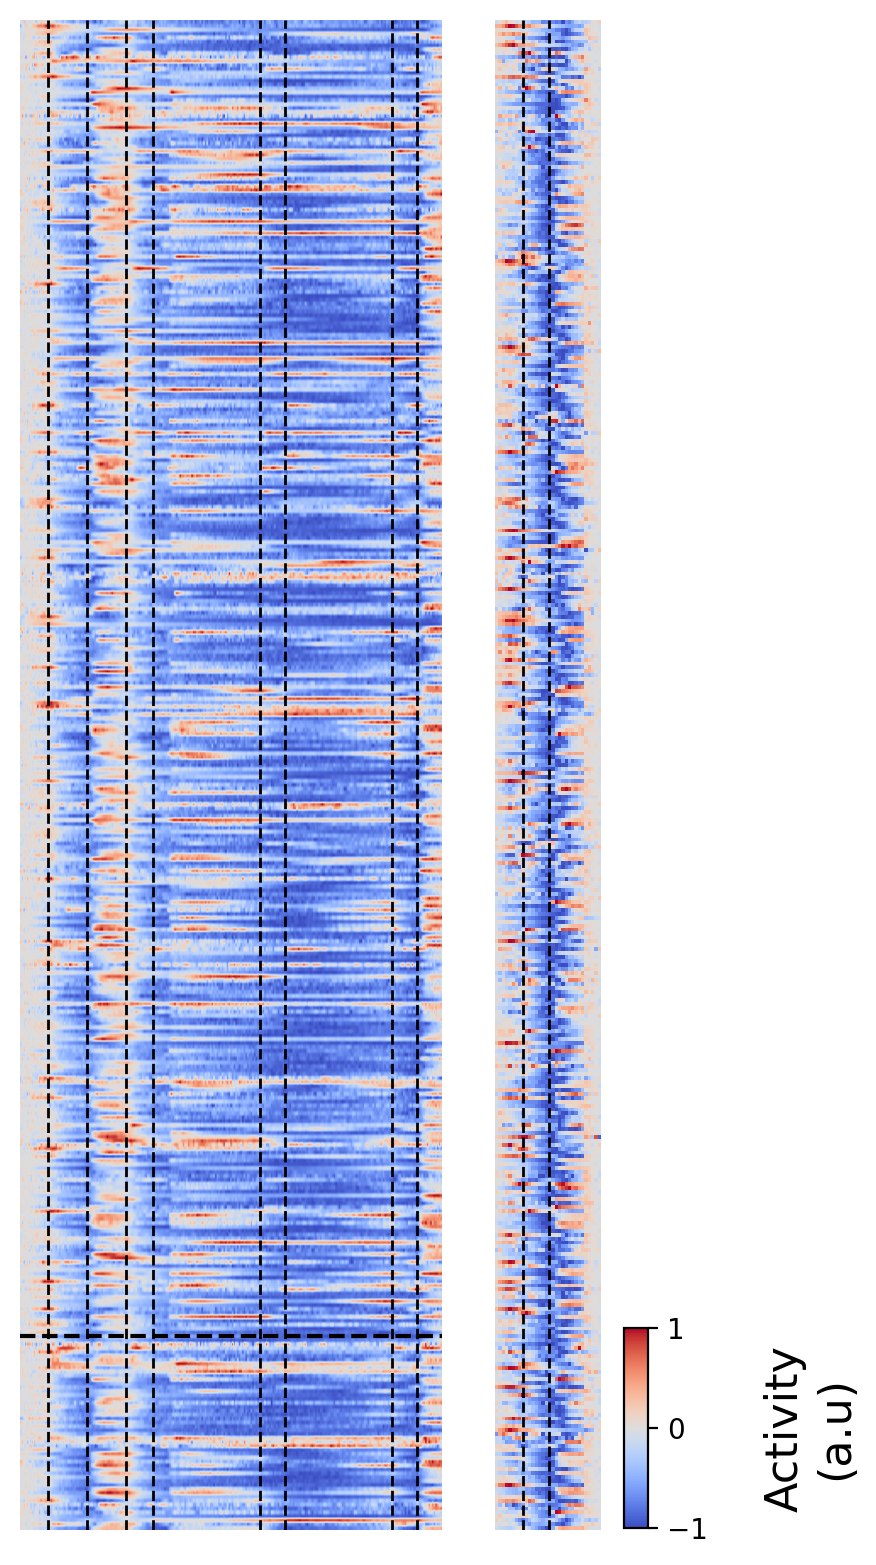

In [179]:
fig, ax = plt.subplots(1,2,figsize=(4,10),gridspec_kw={'width_ratios': [4, 1]})


ax[0].imshow(ctrl_chirp_both_pseudo_shuffled[ctrl_chirp_both_pseudo_shuffled[:, 0].argsort()][:,1:],aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
cax = ax[1].imshow(ctrl_bar_both_pseudo_shuffled[ctrl_bar_both_pseudo_shuffled[:, 0].argsort()][:,1:],aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
# lines chirp
ax[0].axvline(round(7.81*2),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*5),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*8),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*10),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*18),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*20),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*28),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*30),ls='--',color='k',lw=1)

# lines MB
ax[1].axvline(round(7.81*1.),ls='--',color='k',lw=1)
ax[1].axvline(round(7.81*2.),ls='--',color='k',lw=1)

ax[0].axhline(ctrl_chirp_both_pseudo_shuffled.shape[0]-50,ls='--',color='k')

ax[0].axis('off')
ax[1].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.126, 0.03, 0.1])
cbar = fig.colorbar(cax, cax=cbar_ax, shrink=0.92)
cbar.set_label('Activity\n(a.u)', rotation=90,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

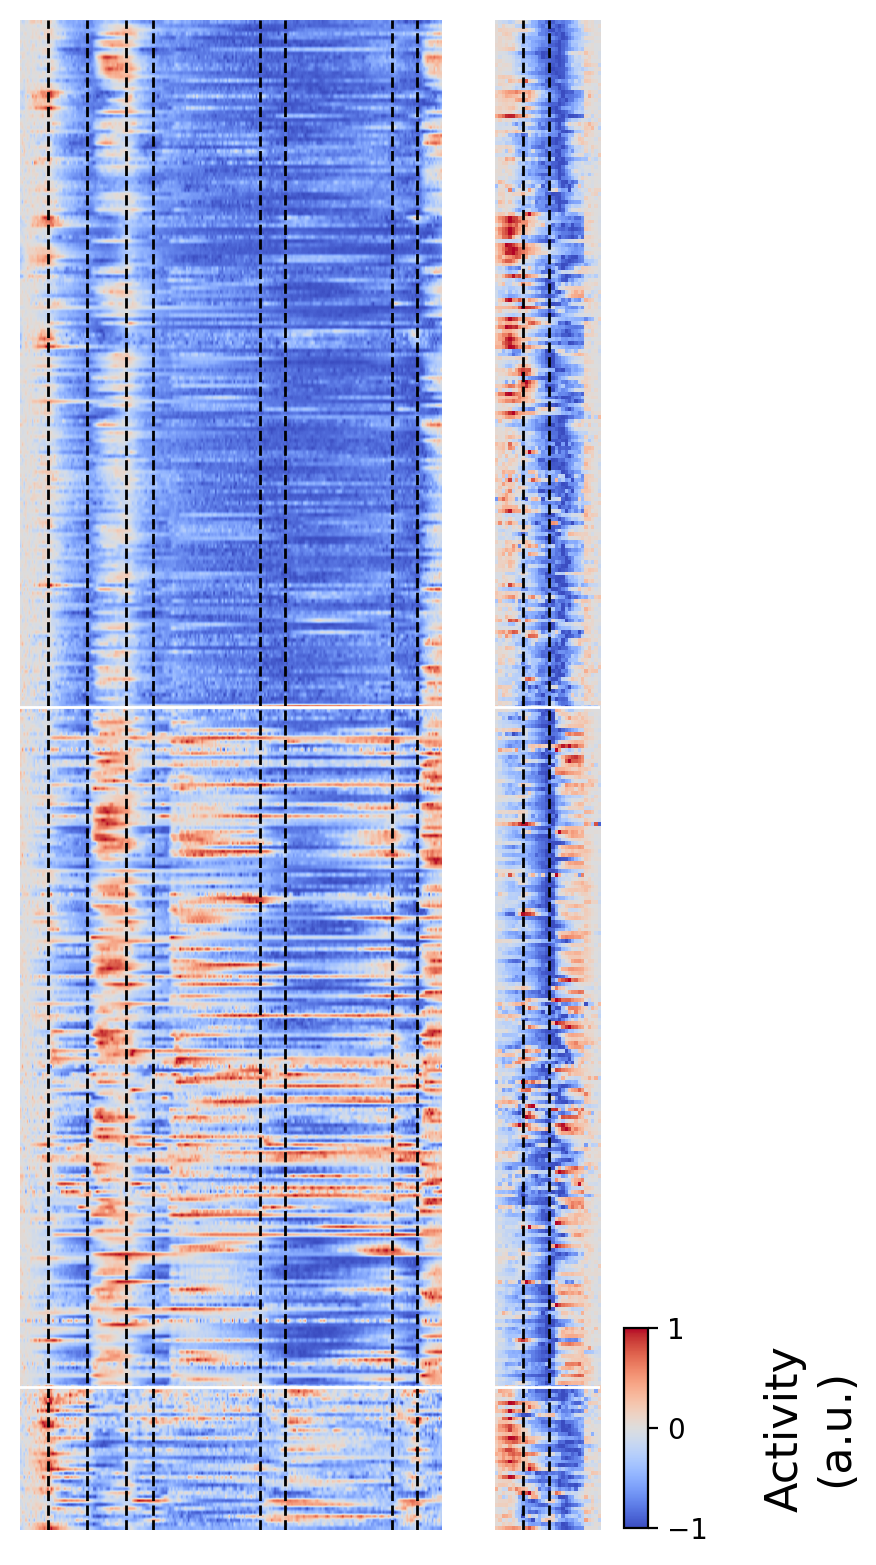

In [180]:
fig, ax = plt.subplots(1,2,figsize=(4,10),gridspec_kw={'width_ratios': [4, 1]})

ax[0].imshow(chirp_label[chirp_label[:, 0].argsort()][:,1:],aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
cax = ax[1].imshow(bar_label[bar_label[:, 0].argsort()][:,1:],aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)

# lines chirp
ax[0].axvline(round(7.81*2),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*5),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*8),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*10),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*18),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*20),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*28),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*30),ls='--',color='k',lw=1)

# lines MB
ax[1].axvline(round(7.81*1.),ls='--',color='k',lw=1)
ax[1].axvline(round(7.81*2.),ls='--',color='k',lw=1)

# add cluster lines to separate them
for i in range(n_cluster_lowest_bic):#-1):
    ax[0].axhline(np.cumsum(cluster_lines)[i],color='white',lw=1,ls='-')
    ax[1].axhline(np.cumsum(cluster_lines)[i],color='white',lw=1,ls='-')

ax[0].axis('off')
ax[1].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.126, 0.03, 0.1])
cbar = fig.colorbar(cax, cax=cbar_ax, shrink=0.92)
cbar.set_label('Activity\n(a.u.)', rotation=90,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

## plot mean traces

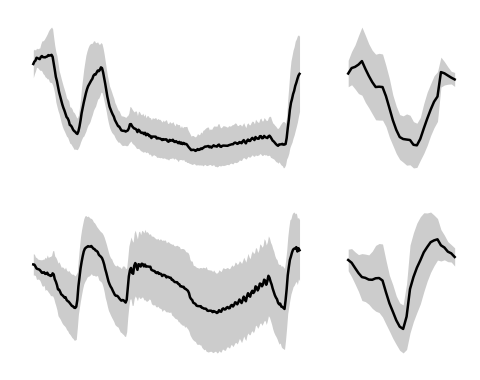

In [181]:
num_clusters = len(np.unique(cluster_labels))

fig,ax = plt.subplots(n_cluster_lowest_bic,2,figsize=(2.5,2),gridspec_kw={'width_ratios': [2.5, 1.]})

for i in range(0,n_cluster_lowest_bic):
    idx = np.where(chirp_label[:,0]==i)[0]
    
    # Ctrl 1
    ax[i,0].plot(np.mean(chirp_label[idx,1:],axis=0),color='black',lw=0.9)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(chirp_label[idx,1:],axis=0)+np.std(chirp_label[idx,1:],axis=0),np.mean(chirp_label[idx,1:],axis=0)-np.std(chirp_label[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,0].axis('off')
    #ax[i,0].set_title('Cluster ID: ' + str(i) + ' Ctrl\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,1].plot(np.mean(bar_label[idx,1:],axis=0),color='black',lw=0.9)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(bar_label[idx,1:],axis=0)+np.std(bar_label[idx,1:],axis=0),np.mean(bar_label[idx,1:],axis=0)-np.std(bar_label[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].axis('off')

fig.tight_layout()    

## plot corrected BIC and # cells plot

In [182]:
n_cells_per_cluster_sbc = np.zeros(n_cluster_lowest_bic)
for i in range(n_cluster_lowest_bic):
    n_cells_per_cluster_sbc[i] = np.where(chirp_label[:, 0]==i)[0].shape[0]

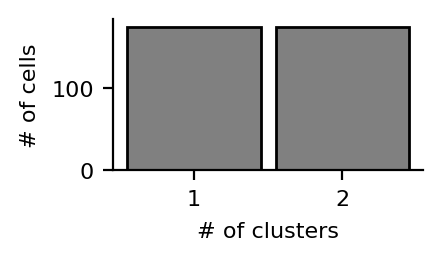

In [183]:
fig,ax=plt.subplots(1,1,figsize=(2,1))
ax.bar(np.arange(1,n_cluster_lowest_bic+1,1),n_cells_per_cluster_sbc,color='gray',edgecolor='k',width=.9);
#ax.set_title('SbC')
ax.set_xlabel('# of clusters',fontsize=8)
ax.set_ylabel('# of cells',fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

# sort traces for heatmap by best corr

In [184]:
def argsort_traces(traces):
    """Traces (n_samples x n_time)"""
    assert traces.ndim == 2
    ccs = np.corrcoef(traces)
    ref_idx = np.argmax(np.sum(ccs, axis=0))
    sort_idxs = np.argsort(ccs[ref_idx])
    return sort_idxs

def sort_traces(traces):
    """Traces (n_samples x n_time)"""
    assert traces.ndim == 2
    sort_idxs = argsort_traces(traces)
    return traces[sort_idxs, :]

In [185]:
cluster_1 = np.hstack((chirp_label[np.where(chirp_label[:,0]==0)[0],1:],bar_label[np.where(chirp_label[:,0]==0)[0],1:]))
cluster_2 = np.hstack((chirp_label[np.where(chirp_label[:,0]==1)[0],1:],bar_label[np.where(chirp_label[:,0]==1)[0],1:]))

In [186]:
cluster_1_sorted = sort_traces(cluster_1)
cluster_2_sorted = sort_traces(cluster_2)

chirp_sorted = np.vstack((cluster_1_sorted[:,:249],cluster_2_sorted[:,:249],chirp_label[np.where(chirp_label[:,0]==3)[0],1:]))
bar_sorted = np.vstack((cluster_1_sorted[:,249:],cluster_2_sorted[:,249:],bar_label[np.where(chirp_label[:,0]==3)[0],1:]))

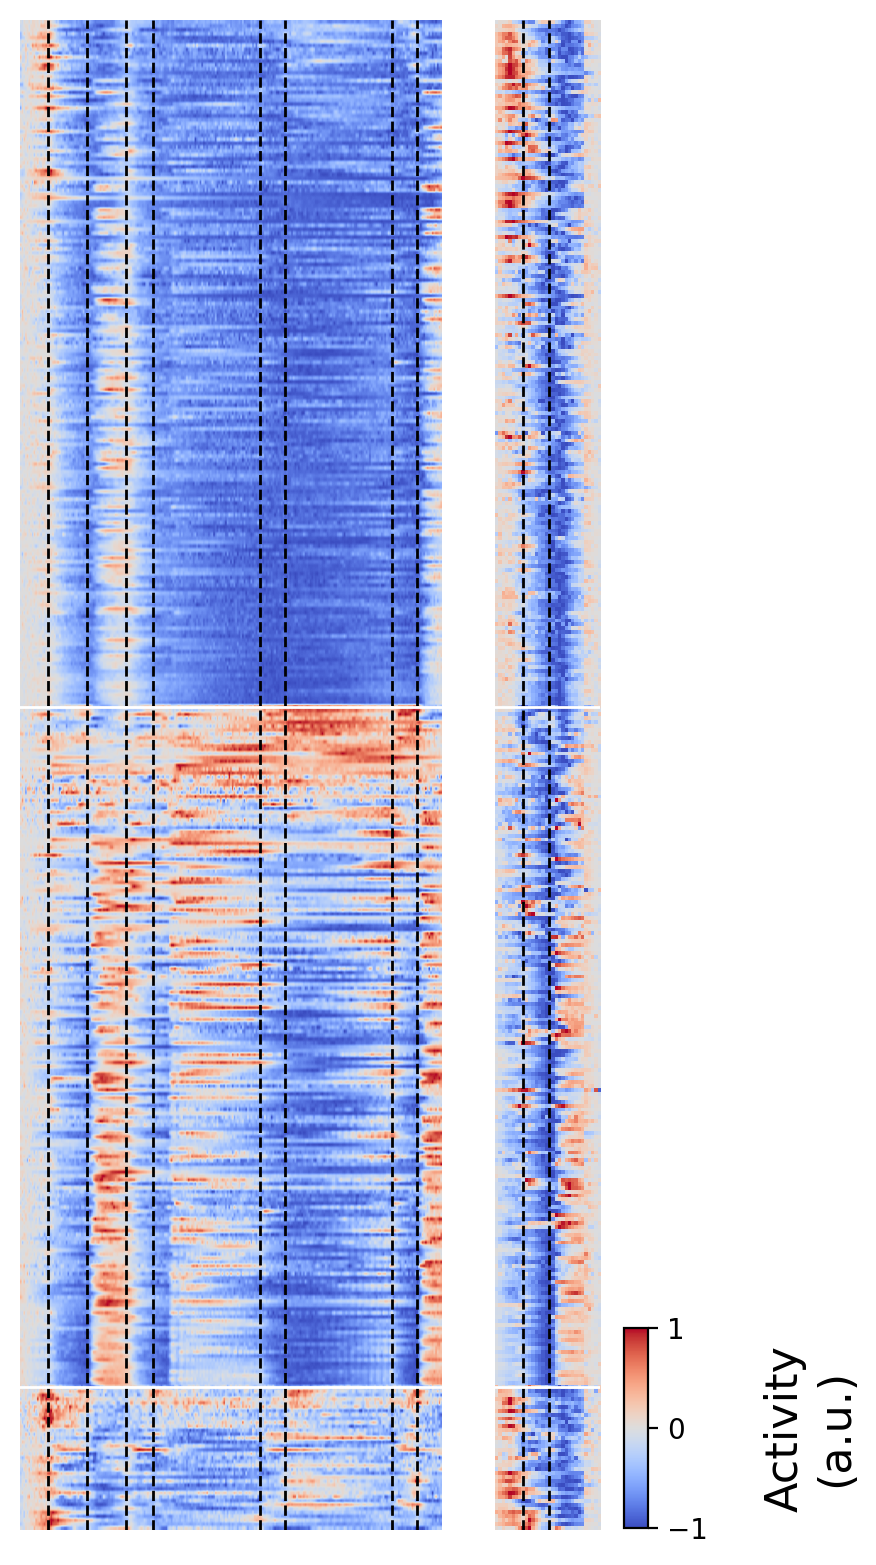

In [187]:
fig, ax = plt.subplots(1,2,figsize=(4,10),gridspec_kw={'width_ratios': [4, 1]})

ax[0].imshow(chirp_sorted,aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)
cax = ax[1].imshow(bar_sorted,aspect = "auto",cmap='coolwarm',vmin=-1,vmax=1)

# lines chirp
ax[0].axvline(round(7.81*2),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*5),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*8),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*10),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*18),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*20),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*28),ls='--',color='k',lw=1)
ax[0].axvline(round(7.81*30),ls='--',color='k',lw=1)

# lines MB
ax[1].axvline(round(7.81*1.),ls='--',color='k',lw=1)
ax[1].axvline(round(7.81*2.),ls='--',color='k',lw=1)

# add cluster lines to separate them
for i in range(n_cluster_lowest_bic):#-1):
    ax[0].axhline(np.cumsum(cluster_lines)[i],color='white',lw=1,ls='-')
    ax[1].axhline(np.cumsum(cluster_lines)[i],color='white',lw=1,ls='-')

ax[0].axis('off')
ax[1].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.126, 0.03, 0.1])
cbar = fig.colorbar(cax, cax=cbar_ax, shrink=0.92)
cbar.set_label('Activity\n(a.u.)', rotation=90,fontsize=16)
cbar.ax.get_yaxis().labelpad = 20

# add corrcoef

### correlation

In [188]:
corr_ctrl = []
corr_no = []
for i in range(0,2):
    idx = np.where(cluster_labels_ctrl==i)[0]
    #c1_both = np.hstack((dict_c1['chirp'][idx_g32_ctrl][idx,:],dict_c1['bar'][idx_g32_ctrl][idx,:]))
    #c2_both = np.hstack((dict_c2['chirp'][idx_g32_ctrl][idx,:],dict_c2['bar'][idx_g32_ctrl][idx,:]))
    c1_both_temp = c1_both[idx,:]
    c2_both_temp = c2_both[idx,:]
    temp = np.zeros(c1_both_temp.shape[0])
    for j in range(temp.shape[0]):
        temp[j] = np.corrcoef(c2_both_temp[j,:],c1_both_temp[j,:])[0,1]
    corr_ctrl.append(temp)
    
    idx = np.where(cluster_labels_no==i)[0]
    c_both_temp = c_no_both[idx,:]
    no_both_temp = d_no_both[idx,:]
    temp = np.zeros(c_both_temp.shape[0])
    for j in range(temp.shape[0]):
        temp[j] = np.corrcoef(no_both_temp[j,:],c_both_temp[j,:])[0,1]
    corr_no.append(temp)
        
corr_ctrl = np.concatenate(corr_ctrl)
corr_no = np.concatenate(corr_no)

corr_both = np.concatenate((corr_ctrl,corr_no))

In [189]:
df_corr = pd.DataFrame({'r':corr_both,'cluster':cluster_ids_df,'condition':condition_str})

In [190]:
idx = np.where(cluster_label_no==1)[0]
ctrl_no_chirp[idx,1:].shape

(76, 249)

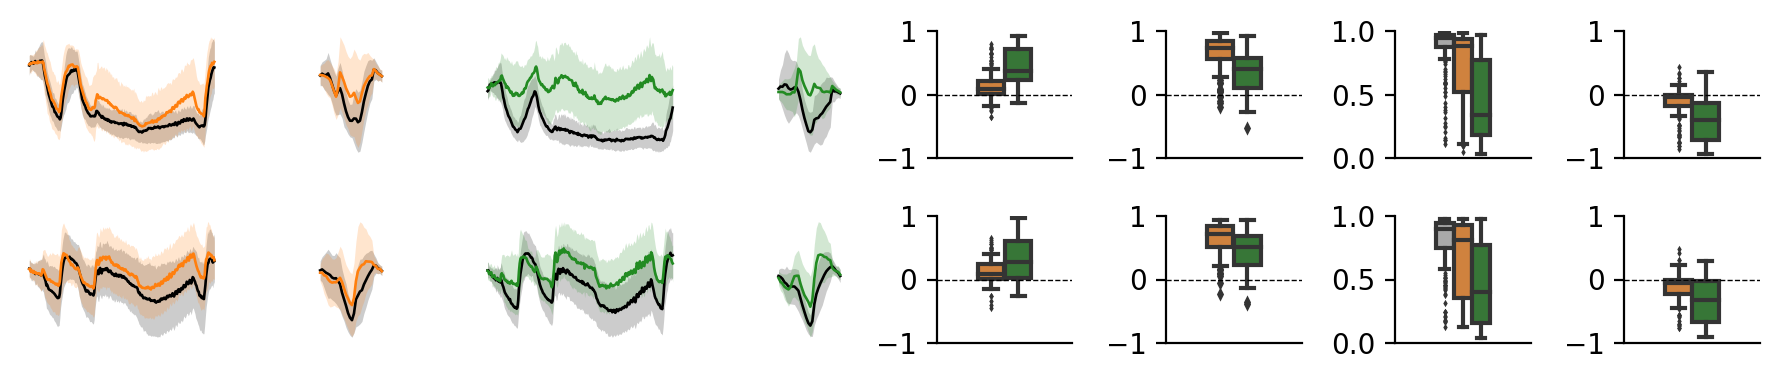

In [110]:
color_ctrl = 'k'
color_ctrl2 = 'tab:orange'
color_no = 'forestgreen'


num_clusters = len(np.unique(cluster_labels))
lw=0.95
fig,ax = plt.subplots(num_clusters,8,figsize=(9,2),gridspec_kw={'width_ratios': [3, 1, 3, 1, 2, 2, 2, 2]})#,sharey=True)

for i in range(0,num_clusters):
    
##########################   
    # Ctrl 1
    idx = np.where(cluster_label_ctrl==i)[0]
    ax[i,0].plot(np.mean(ctrl_c1_chirp[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_c1_chirp[idx,1:],axis=0)+np.std(ctrl_c1_chirp[idx,1:],axis=0),np.mean(ctrl_c1_chirp[idx,1:],axis=0)-np.std(ctrl_c1_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(ctrl_c1_bar[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_c1_bar[idx,1:],axis=0)+np.std(ctrl_c1_bar[idx,1:],axis=0),np.mean(ctrl_c1_bar[idx,1:],axis=0)-np.std(ctrl_c1_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,1].axis('off')
    
    # Ctrl 2
    #idx = np.where(cluster_labels_ctrl==i)[0]
    ax[i,0].plot(np.mean(ctrl_c2_chirp[idx,1:],axis=0),color=color_ctrl2,lw=lw)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_c2_chirp[idx,1:],axis=0)+np.std(ctrl_c2_chirp[idx,1:],axis=0),np.mean(ctrl_c2_chirp[idx,1:],axis=0)-np.std(ctrl_c2_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl2)
    ax[i,0].axis('off')
    
    ax[i,1].plot(np.mean(ctrl_c2_bar[idx,1:],axis=0),color=color_ctrl2,lw=lw)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_c2_bar[idx,1:],axis=0)+np.std(ctrl_c2_bar[idx,1:],axis=0),np.mean(ctrl_c2_bar[idx,1:],axis=0)-np.std(ctrl_c2_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl2)
    ax[i,1].axis('off')
    
##########################   
    # Ctrl
    idx = np.where(cluster_label_no==i)[0]
    ax[i,2].plot(np.mean(ctrl_c_chirp[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(ctrl_c_chirp[idx,1:],axis=0)+np.std(ctrl_c_chirp[idx,1:],axis=0),np.mean(ctrl_c_chirp[idx,1:],axis=0)-np.std(ctrl_c_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,2].axis('off')
    
    ax[i,3].plot(np.mean(ctrl_c_bar[idx,1:],axis=0),color=color_ctrl,lw=lw)
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(ctrl_c_bar[idx,1:],axis=0)+np.std(ctrl_c_bar[idx,1:],axis=0),np.mean(ctrl_c_bar[idx,1:],axis=0)-np.std(ctrl_c_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_ctrl)
    ax[i,3].axis('off')
    
    # DETA/NO
    #idx_no = np.where(cluster_labels_no==i)[0]
    ax[i,2].plot(np.mean(ctrl_no_chirp[idx,1:],axis=0),color=color_no,lw=lw)
    ax[i,2].fill_between(np.arange(0,249,1),np.mean(ctrl_no_chirp[idx,1:],axis=0)+np.std(ctrl_no_chirp[idx,1:],axis=0),np.mean(ctrl_no_chirp[idx,1:],axis=0)-np.std(ctrl_no_chirp[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_no)
    ax[i,2].axis('off')
    #ax[i,2].set_title('ID: ' + str(i))# + ' Ctrl/NO\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,3].plot(np.mean(ctrl_no_bar[idx,1:],axis=0),color=color_no,lw=lw)
    ax[i,3].fill_between(np.arange(0,32,1),np.mean(ctrl_no_bar[idx,1:],axis=0)+np.std(ctrl_no_bar[idx,1:],axis=0),np.mean(ctrl_no_bar[idx,1:],axis=0)-np.std(ctrl_no_bar[idx,1:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color=color_no)
    ax[i,3].axis('off')
    
##########################   
    # Difference
    s1 = sns.boxplot(data=df_diff[df_diff['cluster']==i],
                y='diff',
                x='cluster',
                hue='condition',
                saturation=0.6,
                fliersize=0.5,
                whis=1.,
                dodge=True,
                width=0.4,
                orient='v',
                ax=ax[i,4],
                palette=([color_ctrl2,color_no]),
                boxprops=dict(alpha=1))
    ax[i,4].legend([],[],frameon=False)
    ax[i,4].axhline(0,lw=0.5,ls='--',color='k')
    ax[i,4].set_ylim(-1,1)
    s1.set(ylabel=None)
        
### correlation coefficient        
    s2 = sns.boxplot(data=df_corr[df_corr['cluster']==i],
                y='r',
                x='cluster',
                hue='condition',
                saturation=0.6,
                fliersize=2,
                whis=1.,
                dodge=True,
                width=0.4,
                orient='v',
                ax=ax[i,5],
                palette=([color_ctrl2,color_no]),
                boxprops=dict(alpha=1))
    ax[i,5].legend([],[],frameon=False)
    ax[i,5].axhline(0,lw=0.5,ls='--',color='k')
    ax[i,5].set_ylim(-1,1)
    s2.set(ylabel=None)        
                
        
### suppression index
    s3 = sns.boxplot(data=df_si[df_si['cluster']==i],
                    y='sup_idx',
                    x='cluster',
                    hue='condition',
                    saturation=0.6,
                    fliersize=0.5,
                    whis=1.,
                    dodge=True,
                    width=0.4,
                    orient='v',
                    ax=ax[i,6],
                    palette=(['darkgray',color_ctrl2,color_no]),
                    boxprops=dict(alpha=1))
    ax[i,6].legend([],[],frameon=False)
    ax[i,6].set_ylim(0,1)
    s3.set(ylabel=None)

### SI difference    
    s4 = sns.boxplot(data=df_si_diff[df_si_diff['cluster']==i],
                    y='sup_idx_diff',
                    x='cluster',
                    hue='condition',
                    saturation=0.6,
                    fliersize=0.5,
                    whis=1.,
                    dodge=True,
                    width=0.4,
                    orient='v',
                    ax=ax[i,7],
                    palette=([color_ctrl2,color_no]),
                    boxprops=dict(alpha=1))
    ax[i,7].legend([],[],frameon=False)
    ax[i,7].axhline(0,lw=0.5,ls='--',color='k')
    ax[i,7].set_ylim(-1,1)
    s4.set(ylabel=None)
    
    if i == 0 or i == 1 or i == 2:
        ax[i,4].get_xaxis().set_visible(False)
        ax[i,5].get_xaxis().set_visible(False)
        ax[i,6].get_xaxis().set_visible(False)
        ax[i,7].get_xaxis().set_visible(False)
        
fig.tight_layout()    
sns.despine()

# stats

In [191]:
from scipy.stats import mannwhitneyu
from scipy import stats

### trace difference

In [192]:
diff_p_values_mannu=np.zeros(2)
diff_p_values_ttest=np.zeros(2)
diff_p_values_tests=np.zeros((2,2))

for i in range(2):              
    ctrl=df_diff[(df_diff['cluster']==i) & (df_diff['condition']=='ctrl')]['diff'].values
    no=df_diff[(df_diff['cluster']==i) & (df_diff['condition']=='no')]['diff'].values
                        
    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
    
    diff_p_values_mannu[i] = stats.mannwhitneyu(ctrl, no)[1]
    diff_p_values_ttest[i] = stats.ttest_ind(ctrl, no)[1]
    
    if (p_value_shapiro_ctrl>0.05) and (p_value_shapiro_no>0.05):
        diff_p_values_tests[0,i] = 0
        diff_p_values_tests[1,i] = diff_p_values_ttest[i]

    else:
        diff_p_values_tests[0,i] = 1
        diff_p_values_tests[1,i] = diff_p_values_mannu[i]    

In [193]:
print('Trace difference')
print('bonferroni corrected alpha: '+str(0.05/2))
print(('-------------------------'))
for i in range(2):
    print('Cluster '+str(i+1))
    if diff_p_values_tests[0,i] == 0:
        print('norm. dist.')
    else:
        print('not norm. dist.')
    print('p: '+str(diff_p_values_tests[1,i]))
    if diff_p_values_tests[1,i]<0.05/2:
        print('sign. diff')
    else:
        print('n.s.')
    print('-------------------------')

Trace difference
bonferroni corrected alpha: 0.025
-------------------------
Cluster 1
not norm. dist.
p: 4.079431860515962e-10
sign. diff
-------------------------
Cluster 2
not norm. dist.
p: 0.0005564629967427656
sign. diff
-------------------------


### trace correlation

In [119]:
corr_p_values_mannu=np.zeros(2)
corr_p_values_ttest=np.zeros(2)
corr_p_values_tests=np.zeros((2,2))

for i in range(2):
                        
    ctrl=df_corr[(df_corr['cluster']==i) & (df_corr['condition']=='ctrl')]['r'].values
    no=df_corr[(df_corr['cluster']==i) & (df_corr['condition']=='no')]['r'].values
                        
    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
    
    corr_p_values_mannu[i] = stats.mannwhitneyu(ctrl, no)[1]
    corr_p_values_ttest[i] = stats.ttest_ind(ctrl, no)[1]
    
    if (p_value_shapiro_ctrl>0.05) and (p_value_shapiro_no>0.05):
        corr_p_values_tests[0,i] = 0
        corr_p_values_tests[1,i] = corr_p_values_ttest[i]

    else:
        corr_p_values_tests[0,i] = 1
        corr_p_values_tests[1,i] = corr_p_values_mannu[i]    

In [120]:
print('Correlation coefficient')
print('bonferroni corrected alpha: '+str(0.05/2))
print(('-------------------------'))
for i in range(2):
    print('Cluster '+str(i+1))
    if corr_p_values_tests[0,i] == 0:
        print('norm. dist.')
    else:
        print('not norm. dist.')
    print('p: '+str(corr_p_values_tests[1,i]))
    if corr_p_values_tests[1,i]<0.05/2:
        print('sign. diff')
    else:
        print('n.s.')
    print('-------------------------')

Correlation coefficient
bonferroni corrected alpha: 0.025
-------------------------
Cluster 1
not norm. dist.
p: 1.6903036173990065e-09
sign. diff
-------------------------
Cluster 2
not norm. dist.
p: 1.9791914852295517e-05
sign. diff
-------------------------


### suppression index

In [121]:
si_p_values_kruskal=np.zeros(2)

for i in range(2):
    ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
    ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
    no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
                        
    #p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    #p_value_shapiro_no = stats.shapiro(no)[1]
    
    si_p_values_kruskal[i] = stats.kruskal(ctrl, ctrl2, no)[1]

### posthoc Dunn test

In [122]:
import scikit_posthocs as sp

In [123]:
i=0
ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
data = [ctrl,ctrl2,no]
dunn_results_cluster_1 = sp.posthoc_dunn(data, p_adjust = 'bonferroni')

i=1
ctrl=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl')]['sup_idx'].values                        
ctrl2=df_si[(df_si['cluster']==i) & (df_si['condition']=='ctrl2')]['sup_idx'].values
no=df_si[(df_si['cluster']==i) & (df_si['condition']=='NO')]['sup_idx'].values
data = [ctrl,ctrl2,no]
dunn_results_cluster_2 = sp.posthoc_dunn(data, p_adjust = 'bonferroni')

In [124]:
print('Suppression Index')
print("Dunn's test")
print('bonferroni corrected alpha: '+str(0.05/3))
print('--------------------------')
print('Cluster 1')
print('Ctrl 1 vs. Ctrl 2; p-value: '+str(dunn_results_cluster_1.iloc[0,1])+';sign. diff.')
print('Ctrl 1 vs. NO; p-value: '+str(dunn_results_cluster_1.iloc[0,2])+'; sign. diff.')
print('Ctrl 2 vs. NO; p-value: '+str(dunn_results_cluster_1.iloc[1,2])+'; sign. diff.')

print('--------------------------')
print('Cluster 2')
print('Ctrl 1 vs. Ctrl 2; p-value: '+str(dunn_results_cluster_2.iloc[0,1])+'; sign. diff.')
print('Ctrl 1 vs. NO; p-value: '+str(dunn_results_cluster_2.iloc[0,2])+'; sign. diff.')
print('Ctrl 2 vs. NO; p-value: '+str(dunn_results_cluster_2.iloc[1,2])+'; sign. diff.')

Suppression Index
Dunn's test
bonferroni corrected alpha: 0.016666666666666666
--------------------------
Cluster 1
Ctrl 1 vs. Ctrl 2; p-value: 7.950098671796194e-06;sign. diff.
Ctrl 1 vs. NO; p-value: 4.466295128178703e-17; sign. diff.
Ctrl 2 vs. NO; p-value: 3.8176590131620215e-06; sign. diff.
--------------------------
Cluster 2
Ctrl 1 vs. Ctrl 2; p-value: 0.003912710282822762; sign. diff.
Ctrl 1 vs. NO; p-value: 5.2590502783204045e-14; sign. diff.
Ctrl 2 vs. NO; p-value: 6.679704565937972e-05; sign. diff.


### difference suppression index

In [125]:
si_diff_p_values_mannu=np.zeros(2)
si_diff_p_values_ttest=np.zeros(2)
si_diff_p_values_tests=np.zeros((2,2))

for i in range(2):
    ctrl=df_si_diff[(df_si_diff['cluster']==i) & (df_si_diff['condition']=='ctrl')]['sup_idx_diff'].values
    no=df_si_diff[(df_si_diff['cluster']==i) & (df_si_diff['condition']=='NO')]['sup_idx_diff'].values
         
        
    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
    
    si_diff_p_values_mannu[i] = stats.mannwhitneyu(ctrl, no)[1]
    si_diff_p_values_ttest[i] = stats.ttest_ind(ctrl, no)[1]
    
    if (p_value_shapiro_ctrl>0.05) and (p_value_shapiro_no>0.05):
        si_diff_p_values_tests[0,i] = 0
        si_diff_p_values_tests[1,i] = si_diff_p_values_ttest[i]

    else:
        si_diff_p_values_tests[0,i] = 1
        si_diff_p_values_tests[1,i] = si_diff_p_values_mannu[i]    

In [126]:
print('Difference Suppression Index')
print('bonferroni corrected alpha: '+str(0.05/2))
print(('-------------------------'))
for i in range(2):
    print('Cluster '+str(i+1))
    if si_diff_p_values_tests[0,i] == 0:
        print('norm. dist.')
    else:
        print('not norm. dist.')
    print('p: '+str(si_diff_p_values_tests[1,i]))
    if si_diff_p_values_tests[1,i]<0.05/2:
        print('sign. diff')
    else:
        print('n.s.')
    print('-------------------------')

Difference Suppression Index
bonferroni corrected alpha: 0.025
-------------------------
Cluster 1
not norm. dist.
p: 3.059827654477371e-09
sign. diff
-------------------------
Cluster 2
not norm. dist.
p: 0.00013979159883725396
sign. diff
-------------------------


# Ctrl and NO different from zero

In [127]:
p_values_ctrl = np.zeros((2,2))
p_values_no = np.zeros((2,2))

for i in range(2):              
    ctrl=df_diff[(df_diff['cluster']==i) & (df_diff['condition']=='ctrl')]['diff'].values
    no=df_diff[(df_diff['cluster']==i) & (df_diff['condition']=='no')]['diff'].values

    p_value_shapiro_ctrl = stats.shapiro(ctrl)[1]
    p_value_shapiro_no = stats.shapiro(no)[1]
        
    if p_value_shapiro_ctrl>0.05:
        p_values_ctrl[0,i] = 0
        p_values_ctrl[1,i] = stats.wilcoxon(ctrl, zero_method='wilcox', alternative='two-sided')[1]
        
    elif p_value_shapiro_ctrl<0.05:
        p_values_ctrl[0,i] = 1
        p_values_ctrl[1,i] = stats.ttest_1samp(ctrl, popmean=0.0)[1]
        
    if p_value_shapiro_no>0.05:
        p_values_no[0,i] = 0
        p_values_no[1,i] = stats.wilcoxon(no, zero_method='wilcox', alternative='two-sided')[1]
        
    elif p_value_shapiro_no<0.05:
        p_values_no[0,i] = 1
        p_values_no[1,i] = stats.ttest_1samp(no, popmean=0.0)[1]

In [130]:
alpha_bonf_corrected = 0.05/3

# -------------------------------------------------------------------------------------

## Ctrl data with 2 and 3 cluster labels

## label with 3 cluster

In [1]:
ctrl_chirp_both = np.asarray(np.vstack((dict_c1['chirp'][idx_g32_ctrl],dict_c_no['chirp'][idx_g32_no])))
ctrl_bar_both = np.asarray(np.vstack((dict_c1['bar'][idx_g32_ctrl],dict_c_no['bar'][idx_g32_no])))

ctrl_both_chirp_mb_all = np.hstack((ctrl_chirp_both,ctrl_bar_both))

NameError: name 'np' is not defined

In [139]:
# standardize traces
sc = StandardScaler()
c_traces_stand_all = sc.fit_transform(ctrl_both_chirp_mb_all)

In [140]:
#select 2 clusters
param_grid = {"n_components": range(1, 3), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)
cluster_labels_2 = grid_search.predict(features_stand)

In [141]:
#select 3 clusters
param_grid = {"n_components": range(1, 4), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)
cluster_labels_3 = grid_search.predict(features_stand)

In [142]:
#select 4 clusters
param_grid = {"n_components": range(4,6), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)
cluster_labels_4 = grid_search.predict(features_stand)

## Ctrl2 and NO data with 2 and 3 cluster labels

In [291]:
ctrl_no_chirp_both = np.asarray(np.vstack((dict_c2['chirp'][idx_g32_ctrl],dict_d_no['chirp'][idx_g32_no])))
ctrl_no_bar_both = np.asarray(np.vstack((dict_c2['bar'][idx_g32_ctrl],dict_d_no['bar'][idx_g32_no])))

c2_no_both_chirp_mb_all = np.hstack((ctrl_no_chirp_both,ctrl_no_bar_both))

In [298]:
scan2_labels = np.zeros(ctrl_no_chirp_both.shape[0])
scan2_labels[dict_c2['chirp'][idx_g32_ctrl].shape[0]:]=1

In [175]:
ctrl_both_cluster_cleaned_n3 = ctrl_both_chirp_mb_all[np.where(cluster_labels_re!=3)[0]]

cluster_labels_cleaned_n3 = cluster_labels_3[np.where(cluster_labels_re!=3)[0]]
cluster_labels_cleaned_n2 = cluster_labels[np.where(cluster_labels_re!=3)[0]]

# -------------------------------------------------------------------------------------

# inter-cluster correlations

### n=2

In [194]:
mean_responses_chirp_ctrl = np.zeros((2,249))
mean_responses_bar_ctrl = np.zeros((2,32))

cluster_id_1 = 0
idx_ctrl_1 = np.where(cluster_label_ctrl==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))
mean_responses_chirp_ctrl[0,:] = np.mean(ctrl_chirp,axis=0)
mean_responses_bar_ctrl[0,:] = np.mean(ctrl_bar,axis=0)


cluster_id_1 = 1
idx_ctrl_1 = np.where(cluster_label_ctrl==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))
mean_responses_chirp_ctrl[1,:] = np.mean(ctrl_chirp,axis=0)
mean_responses_bar_ctrl[1,:] = np.mean(ctrl_bar,axis=0)

In [196]:
inter_corr_chirp_ctrl = np.zeros((mean_responses_chirp_ctrl.shape[0],mean_responses_chirp_ctrl.shape[0]))
inter_corr_bar_ctrl = np.zeros((mean_responses_bar_ctrl.shape[0],mean_responses_bar_ctrl.shape[0]))

In [197]:
for i in range(mean_responses_chirp_ctrl.shape[0]):
    for j in range(mean_responses_chirp_ctrl.shape[0]):
        inter_corr_chirp_ctrl[i,j] = np.corrcoef(mean_responses_chirp_ctrl[i,:],mean_responses_chirp_ctrl[j,:])[0,1]
        inter_corr_bar_ctrl[i,j] = np.corrcoef(mean_responses_bar_ctrl[i,:],mean_responses_bar_ctrl[j,:])[0,1]

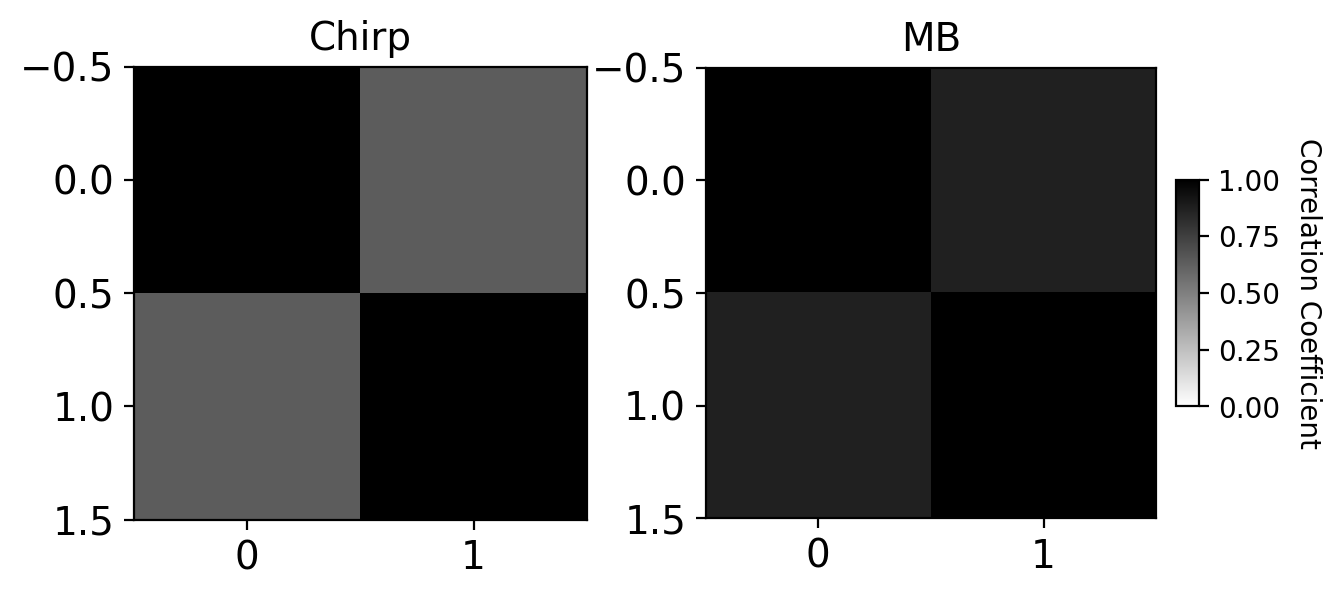

In [198]:
fig,ax=plt.subplots(1,2,figsize=(7,3))

ax[0].imshow(inter_corr_chirp_ctrl,cmap='binary',vmax=1,vmin=0)
ax[0].set_title('')
ax[0].set_title('Chirp',fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)

im = ax[1].imshow(inter_corr_bar_ctrl,cmap='binary',vmax=1,vmin=0)
ax[1].set_title('')
ax[1].set_title('MB',fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

cbar = plt.colorbar(im, aspect=10, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

In [201]:
inter_corr_chirp_ctrl

array([[1.        , 0.63916546],
       [0.63916546, 1.        ]])

In [202]:
inter_corr_bar_ctrl

array([[1.        , 0.87172341],
       [0.87172341, 1.        ]])

## n = 3

In [203]:
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

In [204]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [205]:
transformed_bar = np.delete(traces_transformed, zero_comp_bar, 1)
transformed_chirp = np.delete(traces_transformed_chirp, zero_comp_chirp, 1)

features = np.hstack((transformed_chirp,transformed_bar))
features_stand = sc.fit_transform(features)

In [206]:
#select 3 clusters
param_grid = {"n_components": range(1, 4), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)
cluster_labels_3 = grid_search.predict(features_stand)

In [207]:
chirp_label_cluster_3 = np.hstack((cluster_labels_3[:,None],ctrl_chirp_both))
bar_label_cluster_3 = np.hstack((cluster_labels_3[:,None],ctrl_bar_both))

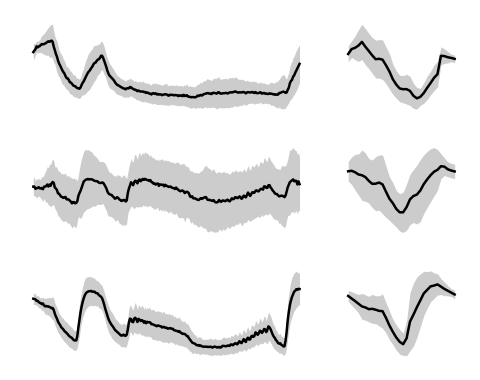

In [208]:
n_cluster_lowest_bic=3


num_clusters = len(np.unique(cluster_labels_3))

fig,ax = plt.subplots(n_cluster_lowest_bic,2,figsize=(2.5,2),gridspec_kw={'width_ratios': [2.5, 1.]})

for i in range(0,n_cluster_lowest_bic):
    idx = np.where(cluster_labels_3==i)[0]
    
    # Ctrl 1
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx,:],axis=0),color='black',lw=0.9)
    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx,:],axis=0)+np.std(ctrl_chirp_both[idx,:],axis=0),np.mean(ctrl_chirp_both[idx,:],axis=0)-np.std(ctrl_chirp_both[idx,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,0].axis('off')
    #ax[i,0].set_title('Cluster ID: ' + str(i) + ' Ctrl\n# Cells: '+str(len(idx)),x=0.8)
    
    ax[i,1].plot(np.mean(ctrl_bar_both[idx,:],axis=0),color='black',lw=0.9)
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx,:],axis=0)+np.std(ctrl_bar_both[idx,:],axis=0),np.mean(ctrl_bar_both[idx,:],axis=0)-np.std(ctrl_bar_both[idx,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].axis('off')

fig.tight_layout()    

In [209]:
label_dataset = np.zeros(ctrl_both.shape[0])
label_dataset[len(idx_g32_ctrl):]=1

In [210]:
chirp_label = np.hstack((cluster_labels_3[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels_3[:,None],ctrl_bar_both))

In [211]:
idx_cluster_2=cluster_labels_3==1

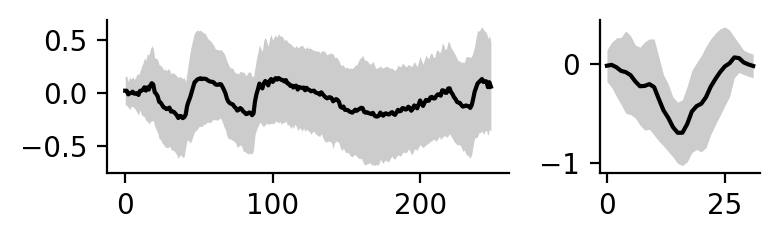

In [212]:
fig,ax=plt.subplots(1,2,figsize=(4,1.3),gridspec_kw={'width_ratios': [2.5, 1.]})
ax[0].plot(np.mean(ctrl_chirp_both[idx_cluster_2],axis=0),color='k')
ax[1].plot(np.mean(ctrl_bar_both[idx_cluster_2],axis=0),color='k')

ax[0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2,:],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2,:],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2,:],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
ax[1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2,:],axis=0)+np.std(ctrl_bar_both[idx_cluster_2,:],axis=0),np.mean(ctrl_bar_both[idx_cluster_2,:],axis=0)-np.std(ctrl_bar_both[idx_cluster_2,:],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
sns.despine()
fig.tight_layout()

In [213]:
ctrl_both_32 = np.hstack((ctrl_chirp_both[idx_cluster_2],ctrl_bar_both[idx_cluster_2]))

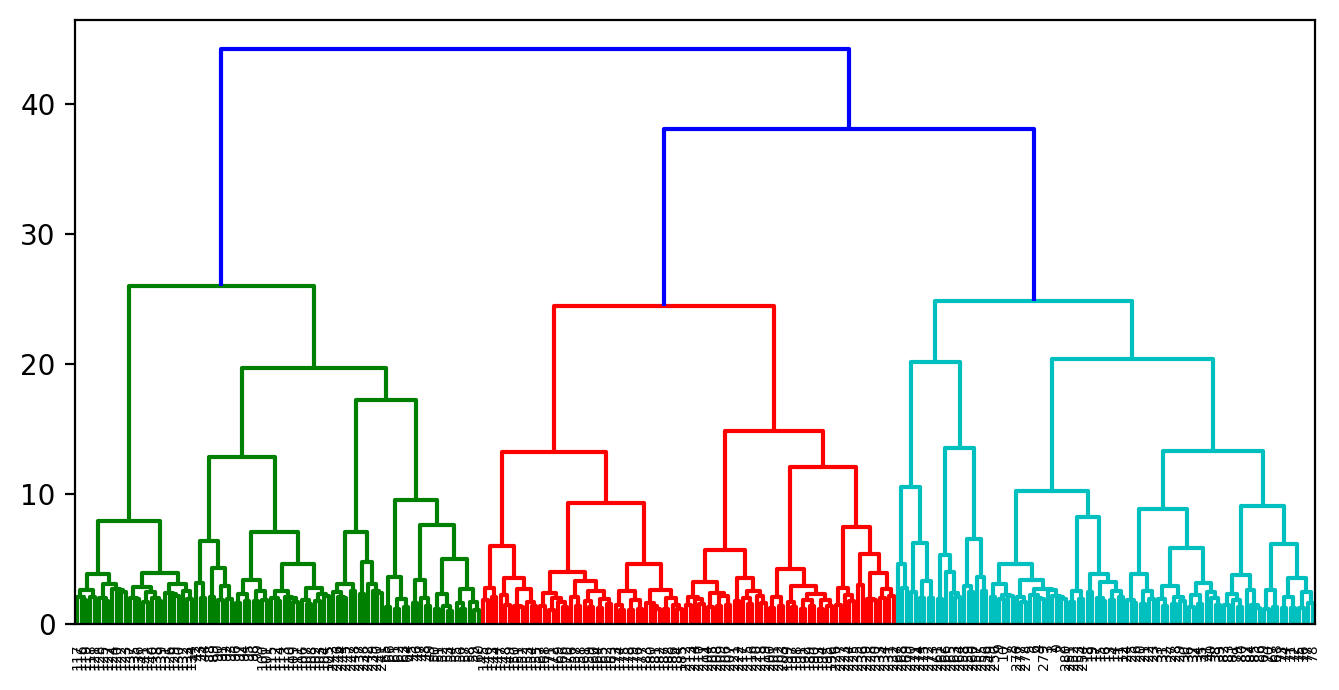

In [214]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
linkage_data = linkage(ctrl_both_32.T, method='ward', metric='euclidean')#,distance_threshold=avg_dist[:30,:30].mean())
dendrogram(linkage_data);
#plt.show() 

In [215]:
n_cluster_cleaned=3

In [216]:
clustering_model = AgglomerativeClustering(n_clusters=n_cluster_cleaned,affinity='euclidean', linkage='ward')
clustering_model.fit(ctrl_both_32)

AgglomerativeClustering(n_clusters=3)

In [217]:
ctrl_chirp_both[idx_cluster_2].shape

(126, 249)

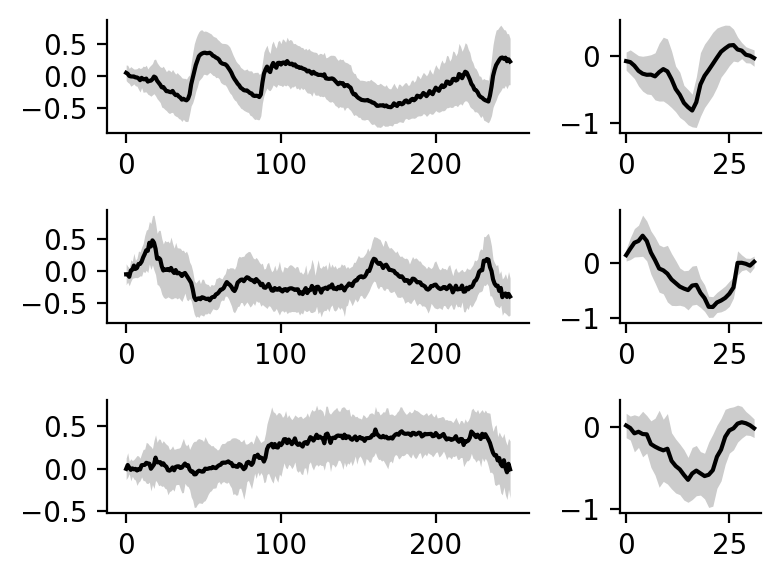

In [218]:
fig,ax = plt.subplots(n_cluster_cleaned,2,figsize=(4,3),gridspec_kw={'width_ratios': [3, 1]})#,sharey=True)

for i in range(0,n_cluster_cleaned):
    idx = np.where(clustering_model.labels_==i)[0]
    
    ax[i,0].plot(np.mean(ctrl_chirp_both[idx_cluster_2][idx],axis=0),color='k')
    ax[i,1].plot(np.mean(ctrl_bar_both[idx_cluster_2][idx],axis=0),color='k')

    ax[i,0].fill_between(np.arange(0,249,1),np.mean(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0)+np.std(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0),np.mean(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0)-np.std(ctrl_chirp_both[idx_cluster_2,:][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')
    ax[i,1].fill_between(np.arange(0,32,1),np.mean(ctrl_bar_both[idx_cluster_2,:][idx],axis=0)+np.std(ctrl_bar_both[idx_cluster_2,:][idx],axis=0),np.mean(ctrl_bar_both[idx_cluster_2,:][idx],axis=0)-np.std(ctrl_bar_both[idx_cluster_2,:][idx],axis=0),alpha=0.2,edgecolor="b", linewidth=0.0,color='black')


sns.despine()
fig.tight_layout()

In [219]:
# combines traces of scan 2
ctrl_chirp_both_scan2 = np.asarray(np.vstack((dict_c2['chirp'][idx_g32_ctrl],dict_d_no['chirp'][idx_g32_no])))
ctrl_bar_both_scan2 = np.asarray(np.vstack((dict_c2['bar'][idx_g32_ctrl],dict_d_no['bar'][idx_g32_no])))

ctrl_both_32_scan2 = np.hstack((ctrl_chirp_both_scan2[idx_cluster_2],ctrl_bar_both_scan2[idx_cluster_2]))

In [220]:
idx = np.where(clustering_model.labels_==0)[0]

In [221]:
idx_ctrl_dataset_1 = np.where(label_dataset[idx_cluster_2][idx]==0)[0]
idx_ctrl_dataset_2 = np.where(label_dataset[idx_cluster_2][idx]==1)[0]

In [222]:
idx_label_2 = np.where(clustering_model.labels_==0)[0]
idx_label_others = np.where(clustering_model.labels_!=0)[0]

# extract only cluster 2 cells that were reclustered
idx_cluster_2 = np.where(cluster_labels_3==2)[0]

# assign another label to the clusters that will be rejcted
cluster_labels_re = cluster_labels_3.copy()
cluster_labels_re[idx_cluster_2[idx_label_others]]=3

In [223]:
chirp_label = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both))
bar_label = np.hstack((cluster_labels_re[:,None],ctrl_bar_both))

In [224]:
chirp_ctrl_label_scan1 = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both))
bar_ctrl_label_scan1 = np.hstack((cluster_labels_re[:,None],ctrl_bar_both))

chirp_ctrl_label_scan2 = np.hstack((cluster_labels_re[:,None],ctrl_chirp_both_scan2))
bar_ctrl_label_scan2 = np.hstack((cluster_labels_re[:,None],ctrl_bar_both_scan2))

In [225]:
ctrl_c1_chirp_cluister_3 = chirp_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_chirp_cluister_3 = chirp_ctrl_label_scan2[np.where(label_dataset==0)[0]]
ctrl_c1_bar_cluister_3 = bar_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_bar_cluister_3 = bar_ctrl_label_scan2[np.where(label_dataset==0)[0]]

ctrl_c_chirp_cluister_3 = chirp_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_chirp_cluister_3 = chirp_ctrl_label_scan2[np.where(label_dataset==1)[0]]
ctrl_c_bar_cluister_3 = bar_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_bar_cluister_3 = bar_ctrl_label_scan2[np.where(label_dataset==1)[0]]

In [226]:
cluster_label_ctrl = ctrl_c1_chirp[:,0].copy()

In [227]:
cluster_label_ctrl_cluster_3 = ctrl_c1_chirp_cluister_3[:,0].copy()
cluster_label_no_cluster_3 = ctrl_c_chirp_cluister_3[:,0].copy()
cluster_ids_df_cluster_3 = np.concatenate((cluster_label_ctrl_cluster_3,cluster_label_no_cluster_3))

In [231]:
cluster_id_1 = 0
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]

In [240]:
ctrl_c1_chirp = chirp_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_chirp = chirp_ctrl_label_scan2[np.where(label_dataset==0)[0]]
ctrl_c1_bar = bar_ctrl_label_scan1[np.where(label_dataset==0)[0]]
ctrl_c2_bar = bar_ctrl_label_scan2[np.where(label_dataset==0)[0]]

ctrl_c_chirp = chirp_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_chirp = chirp_ctrl_label_scan2[np.where(label_dataset==1)[0]]
ctrl_c_bar = bar_ctrl_label_scan1[np.where(label_dataset==1)[0]]
ctrl_no_bar = bar_ctrl_label_scan2[np.where(label_dataset==1)[0]]

In [241]:
mean_responses_chirp_ctrl = np.zeros((3,249))
mean_responses_bar_ctrl = np.zeros((3,32))

cluster_id_1 = 0
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))
mean_responses_chirp_ctrl[0,:] = np.mean(ctrl_chirp,axis=0)
mean_responses_bar_ctrl[0,:] = np.mean(ctrl_bar,axis=0)


cluster_id_1 = 1
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))
mean_responses_chirp_ctrl[1,:] = np.mean(ctrl_chirp,axis=0)
mean_responses_bar_ctrl[1,:] = np.mean(ctrl_bar,axis=0)

cluster_id_1 = 2
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))
mean_responses_chirp_ctrl[2,:] = np.mean(ctrl_chirp,axis=0)
mean_responses_bar_ctrl[2,:] = np.mean(ctrl_bar,axis=0)

In [242]:
inter_corr_chirp_ctrl = np.zeros((mean_responses_chirp_ctrl.shape[0],mean_responses_chirp_ctrl.shape[0]))
inter_corr_bar_ctrl = np.zeros((mean_responses_bar_ctrl.shape[0],mean_responses_bar_ctrl.shape[0]))

In [243]:
for i in range(mean_responses_chirp_ctrl.shape[0]):
    for j in range(mean_responses_chirp_ctrl.shape[0]):
        inter_corr_chirp_ctrl[i,j] = np.corrcoef(mean_responses_chirp_ctrl[i,:],mean_responses_chirp_ctrl[j,:])[0,1]
        inter_corr_bar_ctrl[i,j] = np.corrcoef(mean_responses_bar_ctrl[i,:],mean_responses_bar_ctrl[j,:])[0,1]

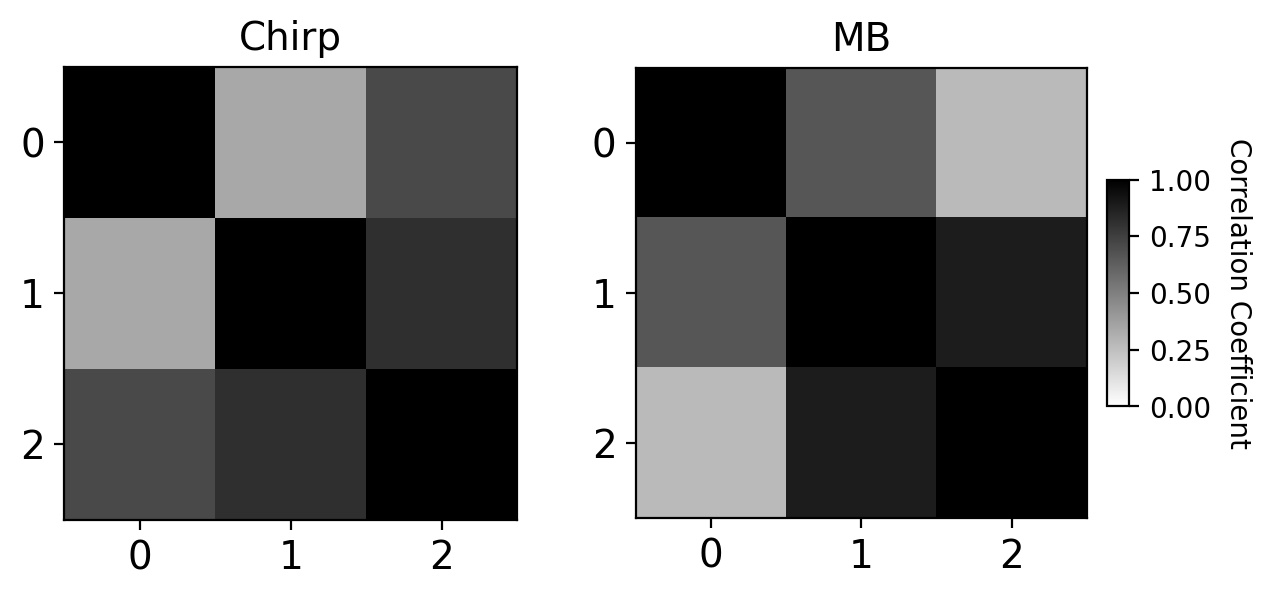

In [244]:
fig,ax=plt.subplots(1,2,figsize=(7,3))

ax[0].imshow(inter_corr_chirp_ctrl,cmap='binary',vmax=1,vmin=0)
ax[0].set_title('')
ax[0].set_title('Chirp',fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)

im = ax[1].imshow(inter_corr_bar_ctrl,cmap='binary',vmax=1,vmin=0)
ax[1].set_title('')
ax[1].set_title('MB',fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

cbar = plt.colorbar(im, aspect=10, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

In [247]:
inter_corr_chirp_ctrl

array([[1.        , 0.34297174, 0.71117985],
       [0.34297174, 1.        , 0.81296118],
       [0.71117985, 0.81296118, 1.        ]])

In [248]:
inter_corr_bar_ctrl

array([[1.        , 0.66314273, 0.26966229],
       [0.66314273, 1.        , 0.8881544 ],
       [0.26966229, 0.8881544 , 1.        ]])

# Intra-cluster correlation

In [113]:
def intra_cluster_correlation(traces, labels):
    
    # preprocess chirp data
    label_ids = np.unique(labels).astype('int')
    mean_corr_per_cluster = np.zeros_like(label_ids,dtype='float')
    std_corr_per_cluster = np.zeros_like(label_ids,dtype='float')

    for count, j in enumerate(label_ids):
        traces_cluster = traces[np.where(labels==j)[0]]
        
        vec_num_cells = np.arange(0,traces_cluster.shape[0],1)
        corr = np.zeros_like(vec_num_cells,dtype='float')

        for i in range(len(vec_num_cells)):
            xxx = np.where(vec_num_cells!=i)[0]
            average_response_leave_one_out = np.mean(traces_cluster[xxx],axis=0)
            #np.std(g1[xxx],axis=0)
            #plt.plot(average_response_leave_one_out)
            #plt.plot(g1[i,:][:,None])
            corr[i] = np.corrcoef(traces_cluster[i,:],average_response_leave_one_out)[0,1]
            if np.isnan(corr[i]):
                corr[i] = 0

        mean_corr_per_cluster[count] = np.mean(corr)
        std_corr_per_cluster[count] = np.std(corr)
        
    return mean_corr_per_cluster, std_corr_per_cluster

# n=2

In [114]:
cluster_id_1 = 0
idx_ctrl_1 = np.where(cluster_label_ctrl==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))

mean_corr_per_cluster_id1_n2, std_corr_per_cluster_id1_n2 = intra_cluster_correlation(traces=ctrl_chirp, labels=cluster_label_ctrl[idx_ctrl_1])

In [115]:
print('Cluster 1 mean:: ' + str(round(mean_corr_per_cluster_id1_n2[0],2)))
print('Cluster 1 std:: ' + str(round(std_corr_per_cluster_id1_n2[0],2)))

Cluster 1 mean:: 0.84
Cluster 1 std:: 0.13


In [116]:
cluster_id_1 = 1
idx_ctrl_1 = np.where(cluster_label_ctrl==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp[idx_ctrl_1,1:],ctrl_c_chirp[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar[idx_ctrl_1,1:],ctrl_c_bar[idx_ctrl_no,1:]))

mean_corr_per_cluster_id2_n2, std_corr_per_cluster_id2_n2 = intra_cluster_correlation(traces=ctrl_chirp, labels=cluster_label_ctrl[idx_ctrl_1])

In [117]:
print('Cluster 2 mean:: ' + str(round(mean_corr_per_cluster_id2_n2[0],2)))
print('Cluster 2 std:: ' + str(round(std_corr_per_cluster_id2_n2[0],2)))

Cluster 2 mean:: 0.48
Cluster 2 std:: 0.45


# n=3

In [118]:
cluster_id_1 = 0
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp_cluister_3[idx_ctrl_1,1:],ctrl_c_chirp_cluister_3[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar_cluister_3[idx_ctrl_1,1:],ctrl_c_bar_cluister_3[idx_ctrl_no,1:]))

mean_corr_per_cluster_id1_n3, std_corr_per_cluster_id1_n3 = intra_cluster_correlation(traces=ctrl_chirp, labels=cluster_label_ctrl_cluster_3[idx_ctrl_1])

In [119]:
print('Cluster 1 mean:: ' + str(round(mean_corr_per_cluster_id1_n3[0],2)))
print('Cluster 1 std:: ' + str(round(std_corr_per_cluster_id1_n3[0],2)))

Cluster 1 mean:: 0.81
Cluster 1 std:: 0.16


In [120]:
cluster_id_1 = 2
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp_cluister_3[idx_ctrl_1,1:],ctrl_c_chirp_cluister_3[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar_cluister_3[idx_ctrl_1,1:],ctrl_c_bar_cluister_3[idx_ctrl_no,1:]))

mean_corr_per_cluster_id2_n3, std_corr_per_cluster_id2_n3 = intra_cluster_correlation(traces=ctrl_chirp, labels=cluster_label_ctrl_cluster_3[idx_ctrl_1])

In [121]:
print('Cluster 2 mean:: ' + str(round(mean_corr_per_cluster_id2_n3[0],2)))
print('Cluster 2 std:: ' + str(round(std_corr_per_cluster_id2_n3[0],2)))

Cluster 2 mean:: 0.86
Cluster 2 std:: 0.07


In [122]:
cluster_id_1 = 3
idx_ctrl_1 = np.where(cluster_label_ctrl_cluster_3==cluster_id_1)[0]
idx_ctrl_no = np.where(cluster_label_no_cluster_3==cluster_id_1)[0]
ctrl_chirp = np.vstack((ctrl_c1_chirp_cluister_3[idx_ctrl_1,1:],ctrl_c_chirp_cluister_3[idx_ctrl_no,1:]))
ctrl_bar = np.vstack((ctrl_c1_bar_cluister_3[idx_ctrl_1,1:],ctrl_c_bar_cluister_3[idx_ctrl_no,1:]))

mean_corr_per_cluster_id3_n3, std_corr_per_cluster_id3_n3 = intra_cluster_correlation(traces=ctrl_chirp, labels=cluster_label_ctrl_cluster_3[idx_ctrl_1])

In [123]:
print('Cluster 3 mean:: ' + str(round(mean_corr_per_cluster_id3_n3[0],2)))
print('Cluster 3 std:: ' + str(round(std_corr_per_cluster_id3_n3[0],2)))

Cluster 3 mean:: 0.83
Cluster 3 std:: 0.1


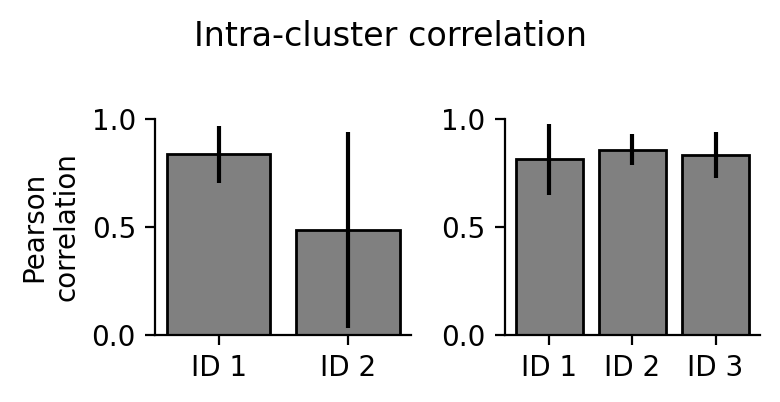

In [144]:
fig,ax=plt.subplots(1,2,figsize=(4,2))

labels_n2 = ['ID 1', 'ID 2']
x_tick_n2 = np.arange(len(labels_n2))
labels_n3 = ['ID 1', 'ID 2', 'ID 3']
x_tick_n3 = np.arange(len(labels_n3))


ax[0].bar(np.arange(0,2),[mean_corr_per_cluster_id1_n2[0],mean_corr_per_cluster_id2_n2[0]],yerr=[std_corr_per_cluster_id1_n2[0],std_corr_per_cluster_id2_n2[0]],edgecolor='k',color='grey')
ax[1].bar(np.arange(0,3),[mean_corr_per_cluster_id1_n3[0],mean_corr_per_cluster_id2_n3[0],mean_corr_per_cluster_id3_n3[0]],yerr=[std_corr_per_cluster_id1_n3[0],std_corr_per_cluster_id2_n3[0],std_corr_per_cluster_id3_n3[0]],edgecolor='k',color='grey')

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[0].set_xticks(x_tick_n2, labels_n2, fontsize=10)
ax[1].set_xticks(x_tick_n3, labels_n3, fontsize=10)

ax[0].set_ylabel('Pearson\ncorrelation')

fig.suptitle('Intra-cluster correlation')

sns.despine()
fig.tight_layout()